# $\hspace{1.5 cm}$ **Atención: Esta Notebook debe ejecutarse usando Google Colab**

# **Práctica 4**
**Autores:** Levi Malest Villarreal, Ana Gil Molia y José María García Ortiz

# <div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>Ejercicio RC4A (0.5 pts)</strong></div>

Modificar el notebook para que, en lugar de trabajar con las 9 primeras texturas, trabaje con
sólo 5 elegidas por cada grupo de forma libre e individual, y obligatoriamente distintas de las 9 originales.
El dataset completo, con 250 texturas, 100 imágenes por cada una, está disponible en el enlace http:
//movideep.inf.um.es/public/alot250classes.tgz (user: public, password: public). Se deberá
descargar dicho dataset, examinarlo visualmente, y escoger libremente 5 texturas que se considere que
constituyen un subconjunto interesante. Se debe entonces crear un nuevo archivo .tgz con todas las
imágenes de las 5 texturas seleccionadas, subirlo a algún URL público, y adaptar el notebook para que se
ejecute completamente y de modo correcto sobre ellas, en lugar de sobre las 9 originales.

In [1]:
!date

Fri Dec 13 09:23:39 AM UTC 2024


## Imports necesarios

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import skimage
import math
import tensorflow as tf
from tensorflow import keras
from keras import layers, initializers
from pathlib import Path
from skimage import io
from skimage import color
from skimage.transform import rescale
from skimage.filters import gabor_kernel
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

## Exploración y selección de clases + creación del fichero .tgz (ejecución pesada, 20 min.)

### Descarga del dataset de imágenes (250 clases)

Utilizaremos el dataset ALOT ("Amsterdam Library of textures"), que puede encontrarse en este enlace: [https://aloi.science.uva.nl/public_alot/](https://aloi.science.uva.nl/public_alot/).

In [3]:
# ! wget http://movideep.inf.um.es/public/alot9classes.tgz -O alot9classes.tgz --user public --password public
!wget http://movideep.inf.um.es/public/alot250classes.tgz -O alot250classes.tgz --user public --password public    # Utilizamos este enlace para acceder a las 250 clases

# LINK ALTERNATIVO:
# wget https://univmurcia-my.sharepoint.com/:u:/g/personal/pedroe_um_es/EdMsASIjwBFLoeCDNysGRCQBaMeC9ZgsftwolQyEuJArYw?download=1 -O alot9classes.tgz
#! wget https://www.google.com/url?q=https%3A%2F%2Faloi.science.uva.nl%2Fpublic_alot%2F -O alot250classes.tgz


--2024-12-13 09:24:06--  http://movideep.inf.um.es/public/alot250classes.tgz
Resolving movideep.inf.um.es (movideep.inf.um.es)... 155.54.204.108
Connecting to movideep.inf.um.es (movideep.inf.um.es)|155.54.204.108|:80... connected.
HTTP request sent, awaiting response... 401 Unauthorized
Authentication selected: Basic realm="Restricted Content"
Reusing existing connection to movideep.inf.um.es:80.
HTTP request sent, awaiting response... 200 OK
Length: 4102033000 (3.8G) [application/octet-stream]
Saving to: ‘alot250classes.tgz’

alot250classes.tgz  100%[===================>]   3.82G  21.2MB/s    in 1m 52s  

2024-12-13 09:25:58 (34.9 MB/s) - ‘alot250classes.tgz’ saved [4102033000/4102033000]



Hemos modificado los comandos pertinentes para acceder a todo el dataset con 250 clases, para cada una de las cuales se disponde de 100 imágenes (en su resolución más pequeña):

In [4]:
! file alot250classes.tgz

alot250classes.tgz: gzip compressed data, from Unix, original size modulo 2^32 4123095040


In [5]:
! rm -rf alot250classes
! tar xzvf alot250classes.tgz | sort > output.txt
! head -n5 output.txt && echo "..." `grep ".png" output.txt | wc -l` "files in total ..."  && tail -n5 output.txt

alot/
alot/1/
alot/10/
alot/100/
alot/100/100_c1i.png
... 25000 files in total ...
alot/9/9_c4l5r60.png
alot/9/9_c4l8.png
alot/9/9_c4l8r120.png
alot/9/9_c4l8r180.png
alot/9/9_c4l8r60.png


In [6]:
!file alot/1/1_c1i.png

alot/1/1_c1i.png: PNG image data, 384 x 256, 8-bit/color RGB, non-interlaced


### Visualización de imágenes

In [7]:
%%time

def read_images(pathname, gray=False):
  path = Path(pathname)

  labels = sorted([l.name for l in path.iterdir()])   # Necesitamos reordenar la lista de labels despues del primer sort dadas las diferencias entre el sorting para strings y enteros
  labels_int = labels.copy()
  labels_int = [int(x) for x in labels_int]
  labels_int = sorted(labels_int)
  labels = [str(x) for x in labels_int]


  imgs = []
  for classpath in [path / l for l in labels]:
    imgsclass = [io.imread(filepath) for filepath in sorted([p for p in classpath.iterdir()])]
    # Aún tratándose de las imágenes más pequeñas, las escalamos a un tamaño 0.5 del original,
    # para hacer el dataset más tratable computacionalmente:
    imgs.append([rescale(skimage.img_as_float32(img), 0.5, anti_aliasing=True, channel_axis=2) for img in imgsclass])

  # No todas las imágenes tienen exactamente la misma forma -> cogemos un parche centrado y con
  # tamaño igual al de la imagen más pequeña de todas las de entrada:
  allshapes = np.array([np.array(img.shape) for imgsclass in imgs for img in imgsclass])
  H, W, C = np.min(allshapes,axis=0)
  for i, imgsclass in enumerate(imgs):
    for j, img in enumerate(imgsclass):
      Hi, Wi, Ci = img.shape
      imgs[i][j] = np.copy(img[(Hi-H)//2:H+(Hi-H)//2:,(Wi-W)//2:W+(Wi-W)//2:,:])
  allshapes = np.array([np.array(img.shape) for imgsclass in imgs for img in imgsclass])
  assert True == np.all(allshapes == np.array([H,W,C])), f"Some image could not be cut to shape {(H,w,C)}"

  NC = len(imgs)                                 # Número de clases.
  NICs = [len(imgsclass) for imgsclass in imgs]  # Lista de número de imágenes por clase.
  NIs = sum(NICs)                                # Número total de imágenes.
  return imgs, labels, H, W, C, NC, NICs, NIs


CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 12.9 µs


In [8]:
my_path = "alot"
imgs, labels, H, W, C, NC, NICs, NIs = read_images(pathname=my_path)
print(f" Número total de clases: {NC}\n"
      f" Número total de imágenes: {NIs}\n"
      f" Número de imágenes por cada clase: ({[ (i,l+'/',ncs) for (i,l,ncs) in zip(range(len(labels)),labels,NICs)]})\n"
      f" Todas las imágenes escaladas y recortadas a tamaño: {imgs[0][0].shape} (H, W, C = {H}, {W}, {C})\n"
      f" Tipo de datos: {imgs[0][0].dtype}\n"
      f" Rango: [{np.min([np.min(img) for imgsclass in imgs for img in imgsclass])},{np.max([np.max(img) for imgsclass in imgs for img in imgsclass])}]")

 Número total de clases: 250
 Número total de imágenes: 25000
 Número de imágenes por cada clase: ([(0, '1/', 100), (1, '2/', 100), (2, '3/', 100), (3, '4/', 100), (4, '5/', 100), (5, '6/', 100), (6, '7/', 100), (7, '8/', 100), (8, '9/', 100), (9, '10/', 100), (10, '11/', 100), (11, '12/', 100), (12, '13/', 100), (13, '14/', 100), (14, '15/', 100), (15, '16/', 100), (16, '17/', 100), (17, '18/', 100), (18, '19/', 100), (19, '20/', 100), (20, '21/', 100), (21, '22/', 100), (22, '23/', 100), (23, '24/', 100), (24, '25/', 100), (25, '26/', 100), (26, '27/', 100), (27, '28/', 100), (28, '29/', 100), (29, '30/', 100), (30, '31/', 100), (31, '32/', 100), (32, '33/', 100), (33, '34/', 100), (34, '35/', 100), (35, '36/', 100), (36, '37/', 100), (37, '38/', 100), (38, '39/', 100), (39, '40/', 100), (40, '41/', 100), (41, '42/', 100), (42, '43/', 100), (43, '44/', 100), (44, '45/', 100), (45, '46/', 100), (46, '47/', 100), (47, '48/', 100), (48, '49/', 100), (49, '50/', 100), (50, '51/', 100), (

Las imágenes han sido extraídas y procesadas correctamente. Dibujamos ahora 2 imágenes de cada clase par poder seleccionar las 5 clases que nos parezcan más interesantes / apropiadas (tarda 12 min):


In [7]:
%%time

def plot_imgs(imgs, n_imgs_per_class=5, ancho=20, largo=300, title=""):
  assert n_imgs_per_class>=2, "n_imgs_per_class debe ser >=2 en función plot_imgs"
  rows, cols = imgs[0][0].shape[:2]
  aspect_ratio = (rows*NC) / (cols*n_imgs_per_class)
  #fig, axs, = plt.subplots(NC, n_imgs_per_class, figsize=(10.0/aspect_ratio, 10.0),sharex=True, sharey=True)
  fig, axs, = plt.subplots(NC, n_imgs_per_class, figsize=(ancho, largo),sharex=True, sharey=True)
  for r in range(NC):
    for c in range(n_imgs_per_class):
      axs[r,c].imshow(imgs[r][c], cmap="gray")
      axs[r,c].axis("off")
      axs[r,c].set_title(f"Clase {r+1}, Img {c}", fontsize=8)

  if(title != ""):
    fig.suptitle(title, fontsize=20, y=0.925)



CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


In [ ]:
plot_imgs(imgs, 2)

La clase **12** tiene pinta de ser dificil de detectar con cambios de iluminación, incluso suaves. la añadiremos para poner a prueba el modelo. Las clases 23-26 son muy muy parecidas entre sí. Tanto que creo que no merece la pena elegir 2 entre ellas para entrenar el modelo. Sin embargo, las clases **30** y **10** quizá sea interesante incluirlas para ver si son capaces de confundir al modelo. También podemos incluir la clase **77**, algo parecida a 31 y 10 pero visiblemente más distinguible. Por último la clase **83**, se parece bastante a la clase 13.

Por tanto, nuestra selección de clases es: 10,12,30,77,83

### Selección de clases y generar un nuevo .tgz filtrado

In [11]:
import os
import tarfile
import shutil
from google.colab import files

def filtrar_tgz(ruta_original, ruta_nuevo, clases_deseadas, download=True):

    """
    Filtra imágenes de clases específicas de un archivo .tgz y crea un nuevo archivo .tgz.

    Parámetros:
    - ruta_original (str): Ruta del archivo .tgz original.
    - ruta_nuevo (str): Ruta donde se guardará el nuevo archivo .tgz.
    - clases_deseadas (list): Lista de nombres de clases a incluir en el nuevo archivo.
    - download (bool): Si es True, permite descargar el nuevo archivo .tgz en la máquina local.
    """

    # Paso 1: Crear carpetas temporales
    carpeta_temporal = "/content/temp"
    carpeta_filtrada = "/content/filtered"

    os.makedirs(carpeta_temporal, exist_ok=True)
    os.makedirs(carpeta_filtrada, exist_ok=True)

    # Paso 2: Extraer el contenido del archivo .tgz
    with tarfile.open(ruta_original, 'r:gz') as tar:
        tar.extractall(carpeta_temporal)

    # Paso 3: Filtrar las imágenes de las clases deseadas
    for clase in clases_deseadas:
        origen_clase = os.path.join(carpeta_temporal, "alot", clase)
        destino_clase = os.path.join(carpeta_filtrada, "alot5",clase)

        if os.path.exists(origen_clase):
            shutil.copytree(origen_clase, destino_clase)

    # Paso 4: Crear un nuevo archivo .tgz con las imágenes filtradas
    with tarfile.open(ruta_nuevo, "w:gz") as tar:
        tar.add(carpeta_filtrada, arcname=os.path.basename(carpeta_filtrada))

    # Limpieza: Eliminar carpetas temporales
    shutil.rmtree(carpeta_temporal)
    shutil.rmtree(carpeta_filtrada)

    print(f"Nuevo archivo .tgz creado en: {ruta_nuevo}")

    # Paso 5: Descargar el archivo si se solicita
    if download:
        files.download(ruta_nuevo)


In [12]:
# ------------------------ Descargamos el fichero con nuestras 5 clases ----------------------------- #
ruta_original = "alot250classes.tgz"
ruta_nuevo = "alot5classes.tgz"
clases_deseadas = ["10", "12", "30", "77", "83"]

filtrar_tgz(ruta_original, ruta_nuevo, clases_deseadas, download=True)

Nuevo archivo .tgz creado en: alot5classes.tgz


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Subimos a drive el nuevo fichero de (cinco) texturas filtradas de forma externa. A continuación lo descargamos y ese se convertirá en nuestro fichero de trabajo para el resto de la notebook.

## Descargamos el .tgz filtrado desde nuestra URL de acceso público (Ejecutar desde aquí)

In [ ]:
# Para descargar las imágenes necesarias para los comentarios del final de la notebook.

from google.colab import drive
import os
import shutil
import gdown
import zipfile


# IDs de los archivos compartidos (reemplaza con los IDs de tus archivos .zip)
file_ids = ['1uvwBQvi8JUTpMsxokUGt_PZ7VXWSY5Nn']  # Cambia estos IDs por los de tus archivos

# Nombres locales para los archivos descargados y descomprimidos
download_paths = ['/CVFiles2.zip']
extract_paths = ['']

# Descargar y descomprimir cada archivo
for file_id, download_path, extract_path in zip(file_ids, download_paths, extract_paths):
    # Descargar archivo
    gdown.download(f'https://drive.google.com/uc?id={file_id}', download_path, quiet=False)

    # Descomprimir el archivo ZIP
    with zipfile.ZipFile(download_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
        print(f"Archivos descomprimidos en '{extract_path}'")

In [2]:
! wget https://umubox.um.es/index.php/s/1SeVmppm7mi2zlp/download -O alot5classes.tgz

--2024-12-13 10:02:58--  https://umubox.um.es/index.php/s/1SeVmppm7mi2zlp/download
Resolving umubox.um.es (umubox.um.es)... 155.54.212.96, 2001:720:1710:212::1:b
Connecting to umubox.um.es (umubox.um.es)|155.54.212.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72531118 (69M) [application/x-compressed]
Saving to: ‘alot5classes.tgz’

alot5classes.tgz    100%[===================>]  69.17M  2.64MB/s    in 27s     

2024-12-13 10:03:25 (2.60 MB/s) - ‘alot5classes.tgz’ saved [72531118/72531118]



In [3]:
! file alot5classes.tgz

alot5classes.tgz: gzip compressed data, was "alot5classes.tgz", last modified: Thu Dec 12 10:21:05 2024, max compression, original size modulo 2^32 73410560


In [4]:
! rm -rf alot5classes
! tar xzvf alot5classes.tgz | sort > output.txt
! head -n5 output.txt && echo "..." `grep ".png" output.txt | wc -l` "files in total ..."  && tail -n5 output.txt

filtered/
filtered/alot5/
filtered/alot5/10/
filtered/alot5/10/10_c1i.png
filtered/alot5/10/10_c1l1.png
... 500 files in total ...
filtered/alot5/83/83_c4l5r60.png
filtered/alot5/83/83_c4l8.png
filtered/alot5/83/83_c4l8r120.png
filtered/alot5/83/83_c4l8r180.png
filtered/alot5/83/83_c4l8r60.png


In [5]:
! file alot5/1/1_c1i.png

alot5/1/1_c1i.png: cannot open `alot5/1/1_c1i.png' (No such file or directory)


## Leemos y visualizamos las imágenes descargadas de las 5 clases seleccionadas

In [6]:
%%time

def read_images(pathname, gray=False):
  path = Path(pathname)

  labels = sorted([l.name for l in path.iterdir()])   # Necesitamos reordenar la lista de labels despues del primer sort dadas las diferencias entre el sorting para strings y enteros
  labels_int = labels.copy()
  labels_int = [int(x) for x in labels_int]
  labels_int = sorted(labels_int)
  labels = [str(x) for x in labels_int]


  imgs = []
  for classpath in [path / l for l in labels]:
    imgsclass = [io.imread(filepath) for filepath in sorted([p for p in classpath.iterdir()])]
    # Aún tratándose de las imágenes más pequeñas, las escalamos a un tamaño 0.5 del original,
    # para hacer el dataset más tratable computacionalmente:
    imgs.append([rescale(skimage.img_as_float32(img), 0.5, anti_aliasing=True, channel_axis=2) for img in imgsclass])

  # No todas las imágenes tienen exactamente la misma forma -> cogemos un parche centrado y con
  # tamaño igual al de la imagen más pequeña de todas las de entrada:
  allshapes = np.array([np.array(img.shape) for imgsclass in imgs for img in imgsclass])
  H, W, C = np.min(allshapes,axis=0)
  for i, imgsclass in enumerate(imgs):
    for j, img in enumerate(imgsclass):
      Hi, Wi, Ci = img.shape
      imgs[i][j] = np.copy(img[(Hi-H)//2:H+(Hi-H)//2:,(Wi-W)//2:W+(Wi-W)//2:,:])
  allshapes = np.array([np.array(img.shape) for imgsclass in imgs for img in imgsclass])
  assert True == np.all(allshapes == np.array([H,W,C])), f"Some image could not be cut to shape {(H,w,C)}"

  NC = len(imgs)                                 # Número de clases.
  NICs = [len(imgsclass) for imgsclass in imgs]  # Lista de número de imágenes por clase.
  NIs = sum(NICs)                                # Número total de imágenes.
  return imgs, labels, H, W, C, NC, NICs, NIs

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


In [7]:
imgs, labels, H, W, C, NC, NICs, NIs = read_images("filtered/alot5")
print(f" Número total de clases: {NC}\n"
      f" Número total de imágenes: {NIs}\n"
      f" Número de imágenes por cada clase: ({[ (i,l+'/',ncs) for (i,l,ncs) in zip(range(len(labels)),labels,NICs)]})\n"
      f" Todas las imágenes escaladas y recortadas a tamaño: {imgs[0][0].shape} (H, W, C = {H}, {W}, {C})\n"
      f" Tipo de datos: {imgs[0][0].dtype}\n"
      f" Rango: [{np.min([np.min(img) for imgsclass in imgs for img in imgsclass])},{np.max([np.max(img) for imgsclass in imgs for img in imgsclass])}]")

 Número total de clases: 5
 Número total de imágenes: 500
 Número de imágenes por cada clase: ([(0, '10/', 100), (1, '12/', 100), (2, '30/', 100), (3, '77/', 100), (4, '83/', 100)])
 Todas las imágenes escaladas y recortadas a tamaño: (82, 192, 3) (H, W, C = 82, 192, 3)
 Tipo de datos: float32
 Rango: [0.0,0.9960784912109375]


In [8]:
%%time

def plot_imgs(imgs, n_imgs_per_class=5, ancho=20, largo=300, title=""):
  assert n_imgs_per_class>=2, "n_imgs_per_class debe ser >=2 en función plot_imgs"
  rows, cols = imgs[0][0].shape[:2]
  aspect_ratio = (rows*NC) / (cols*n_imgs_per_class)
  #fig, axs, = plt.subplots(NC, n_imgs_per_class, figsize=(10.0/aspect_ratio, 10.0),sharex=True, sharey=True)
  fig, axs, = plt.subplots(NC, n_imgs_per_class, figsize=(ancho, largo),sharex=True, sharey=True)
  for r in range(NC):
    for c in range(n_imgs_per_class):
      axs[r,c].imshow(imgs[r][c], cmap="gray")
      axs[r,c].axis("off")
      axs[r,c].set_title(f"Clase {r+1}, Img {c}", fontsize=8)

  if(title != ""):
    fig.suptitle(title, fontsize=20, y=0.925)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


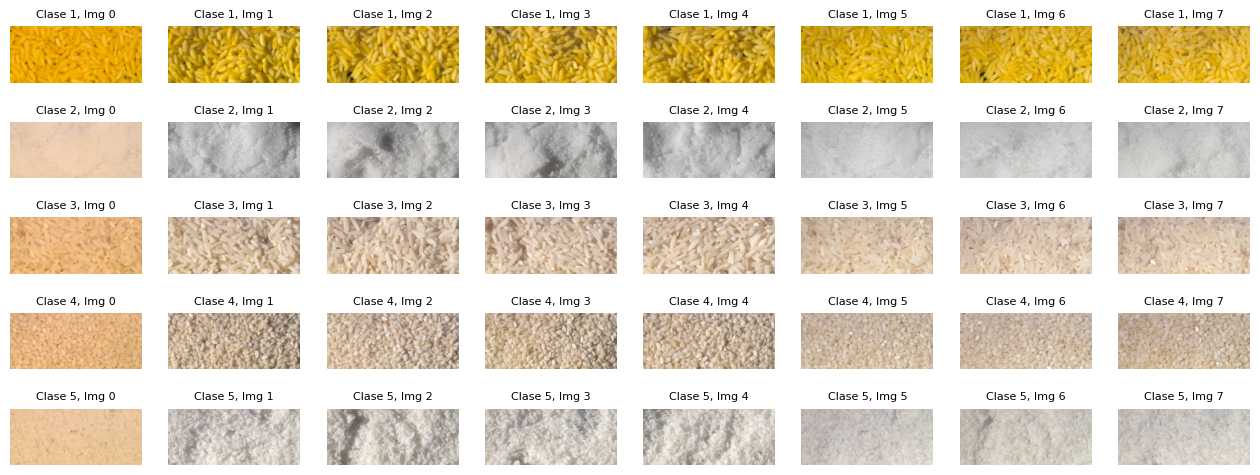

In [9]:
plot_imgs(imgs, n_imgs_per_class=8, ancho=16, largo=6)

Ahora podemos ver más muestras de las texturas escogidas. Notamos que el numero de la clase ha cambiado respecto a los que seleccionábamos antes sobre el dataset de 250 texturas. Vemos que efectivamente las clases 1 y 3 se parecen salvo por el color, y se parecen ligeramente a la clase 4. Por su parte, las clases 2 y 5 resultan faciels de confundir en según que muestras. Esperamos que esta selección sea más o menos retadora para el modelo, es decir, esperamos peores resultados en general que con el modelo base de la notebook original (sin hacer cambios sobre el modelo).

## Generación de parches de entrenamiento/test/validación a partir de las imágenes

Usaremos los siguientes parámetros para generar el dataset de parches:

In [10]:
TS                 = 40         # Tamaño de los parches (tiles).
OVERLAP            = True       # Si los parches serán con solapamiento.
TILE_STRIDE        = 20         # Stride utilizado para obtener los parches (en caso de que OVERLAP sea True).
NIS_TEST           = 10         # Las últimas NIS_TEST + NIS_VAL imágenes de cada clase no se verán
NIS_VAL            = 10         # durante el entrenamiento (10 imágenes para test y 10 para validación).
MAX_SAMPLES        = 30000      # Limitamos el número de parches por experimento.

In [11]:
def split_img_in_tiles(img, tile_size, stride, overlap):
  if not overlap:
    # Parches sin solapamiento (ojo, salen bastante menos parches por imagen):
    return np.array([
        np.array(img[x:x+tile_size,y:y+tile_size])
        for x in range(0,img.shape[0]-tile_size+1,tile_size)
        for y in range(0,img.shape[1]-tile_size+1,tile_size)])
  else:
    # Parches con solapamiento (stride=TILE_STRIDE píxeles; genera muchos más parches por cada imagen):
    return np.array([
        np.array(img[x:x+tile_size,y:y+tile_size])
        for x in range(0,img.shape[0]-tile_size+1,stride)
        for y in range(0,img.shape[1]-tile_size+1,stride)
      ])

def generate_tiles_sets(overlap = False):
  tiles_train, tiles_test, tiles_val = [], [], []
  labels_train, labels_test, labels_val = [], [], []
  # c recorre las NC clases:
  for c in range(len(imgs)):
    # i recorre las imágenes de cada clase; un bucle para crear el conjunto de
    # train, otro para crear el de test, y un tercero para el de validación:
    for i in range(0,NICs[c]-NIS_TEST-NIS_VAL):
      for tile in split_img_in_tiles(imgs[c][i], TS, stride=TILE_STRIDE, overlap=overlap):
        tiles_train.append(tile)
        labels_train.append(c)
    for i in range(NICs[c]-NIS_TEST-NIS_VAL,NICs[c]-NIS_VAL):
      for tile in split_img_in_tiles(imgs[c][i], TS, stride=TILE_STRIDE, overlap=overlap):
        tiles_test.append(tile)
        labels_test.append(c)
    for i in range(NICs[c]-NIS_VAL,NICs[c]):
      for tile in split_img_in_tiles(imgs[c][i], TS, stride=TILE_STRIDE, overlap=overlap):
        tiles_val.append(tile)
        labels_val.append(c)
  tiles_train, tiles_test, tiles_val = np.array(tiles_train), np.array(tiles_test), np.array(tiles_val)
  labels_train, labels_test, labels_val = np.array(labels_train), np.array(labels_test), np.array(labels_val)
  return tiles_train, tiles_test, tiles_val, labels_train, labels_test, labels_val

tiles_train, tiles_test, tiles_val, labels_train, labels_test, labels_val = generate_tiles_sets(OVERLAP)
print(f" Parches por cada imagen: {len(split_img_in_tiles(imgs[0][0], TS, stride=TILE_STRIDE, overlap=OVERLAP))}\n"
      f" Número total de imágenes empleadas para training: {NIs-NC*NIS_TEST-NC*NIS_VAL}\n"
      f" Número total de imágenes empleadas para test: {NC*NIS_TEST}\n"
      f" Número total de imágenes empleadas para validación: {NC*NIS_VAL}\n"
      f" Número total de parches usados para training: {len(tiles_train)}\n"
      f" Número total de parches usados para test: {len(tiles_test)}\n"
      f" Número total de parches usados para validación: {len(tiles_val)}\n"
      f" Número total de parches: {len(tiles_train)+len(tiles_test)+len(tiles_val)}\n"
      f" Dimensiones de cada parche: {tiles_train[0].shape}\n"
      f" Tipo de dato: {tiles_train[0].dtype}\n"
      f" Rango del primer parche de entrenamiento: [{np.min(tiles_train[0])},{np.max(tiles_train[0])}]")

 Parches por cada imagen: 24
 Número total de imágenes empleadas para training: 400
 Número total de imágenes empleadas para test: 50
 Número total de imágenes empleadas para validación: 50
 Número total de parches usados para training: 9600
 Número total de parches usados para test: 1200
 Número total de parches usados para validación: 1200
 Número total de parches: 12000
 Dimensiones de cada parche: (40, 40, 3)
 Tipo de dato: float32
 Rango del primer parche de entrenamiento: [0.0,0.9900431632995605]


Dibujamos los veinte primeros parches por cada clase (una fila por clase), para los conjuntos de training (y, si se desea, también de test y de validación):

CPU times: user 5.75 s, sys: 55.3 ms, total: 5.8 s
Wall time: 5.9 s


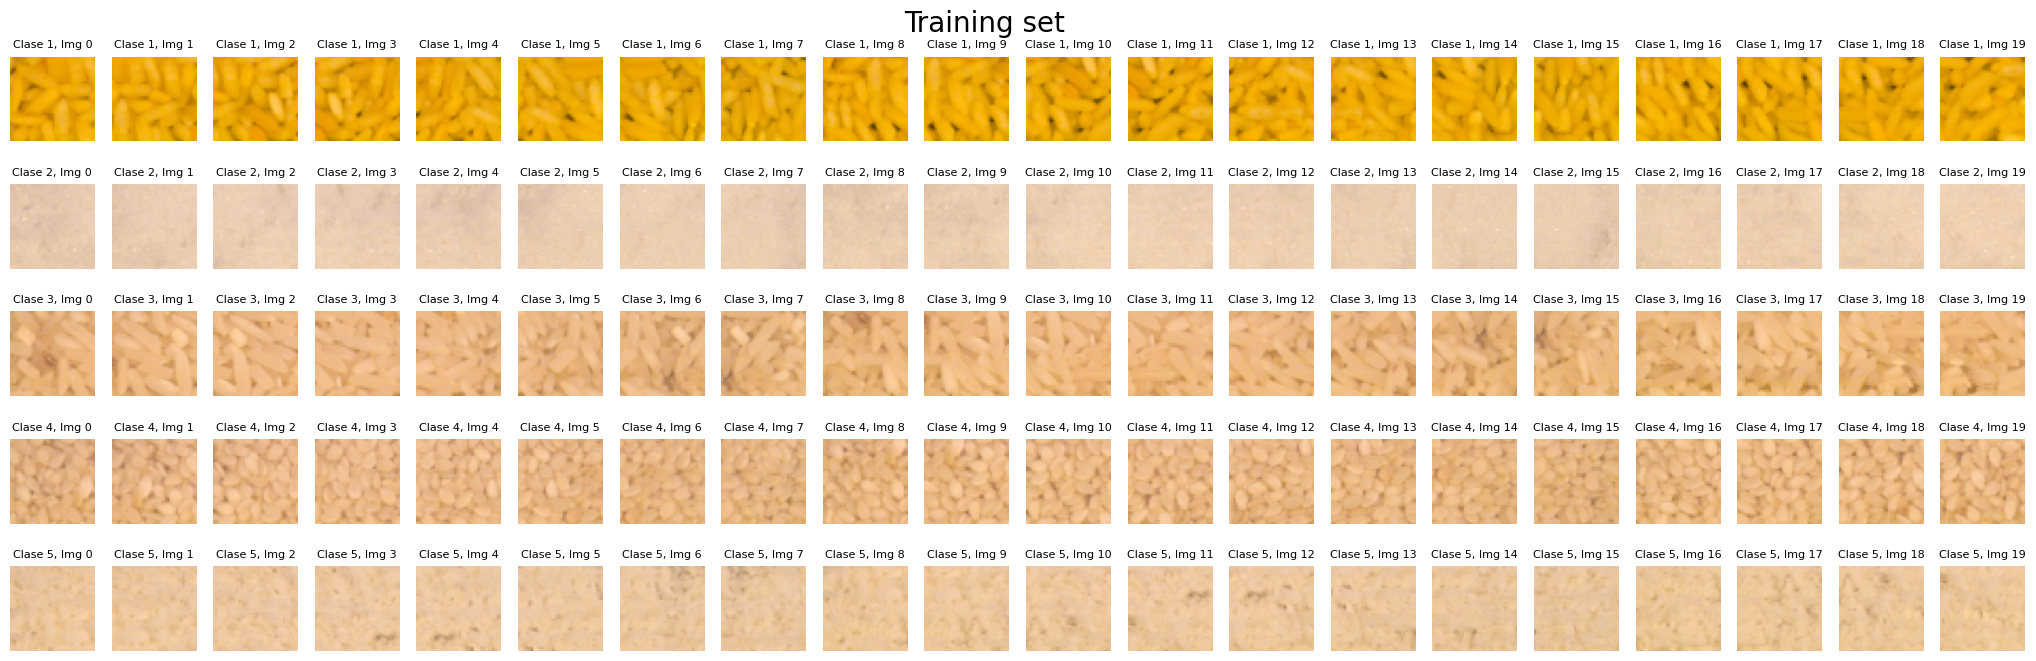

In [12]:
%%time

plot_imgs(tiles_train.reshape(NC, -1, TS, TS, C), 20, ancho=26,largo=8, title="Training set")
# plot_imgs(tiles_test.reshape(NC, -1, TS, TS, C), 20, title="Test set")
# plot_imgs(tiles_val.reshape(NC, -1, TS, TS, C), 20, title="Validation set")

## Conjunto prefijado (_hand engineered_) de filtros de Gabor

Generamos un conjunto de 40 filtros de Gabor (8 orientaciones x 5 combinaciones diferentes de sigmas, frecuencias y fases; explicación detallada de parámetros [aquí](https://www.geeksforgeeks.org/opencv-getgaborkernel-method/)), formando máscaras de tamaño 17x17:

In [13]:
GABOR_ORIENTATIONS = 8
GABOR_SIZE         = 17
GABOR_PARMS        = [(1.5, GABOR_SIZE, 0), (1.5, GABOR_SIZE, np.pi/2), (2.5, GABOR_SIZE/2, 0), (3.5, GABOR_SIZE/3, np.pi/2), (5.0, GABOR_SIZE/1.75, np.pi/2)]
NKGABOR            = GABOR_ORIENTATIONS * len(GABOR_PARMS)   # Número total de filtros de Gabor (escala de grises)
NKGABORRGB         = 3*NKGABOR                               # Número total de filtros de Gabor (RGB)

Número total de filtros (kernels) de Gabor: 40
Forma del tensor de filtros de GABOR sobre imagen de grises: (17, 17, 1, 40)
Forma del tensor de filtros de GABOR sobre imagen RGB: (17, 17, 3, 120)


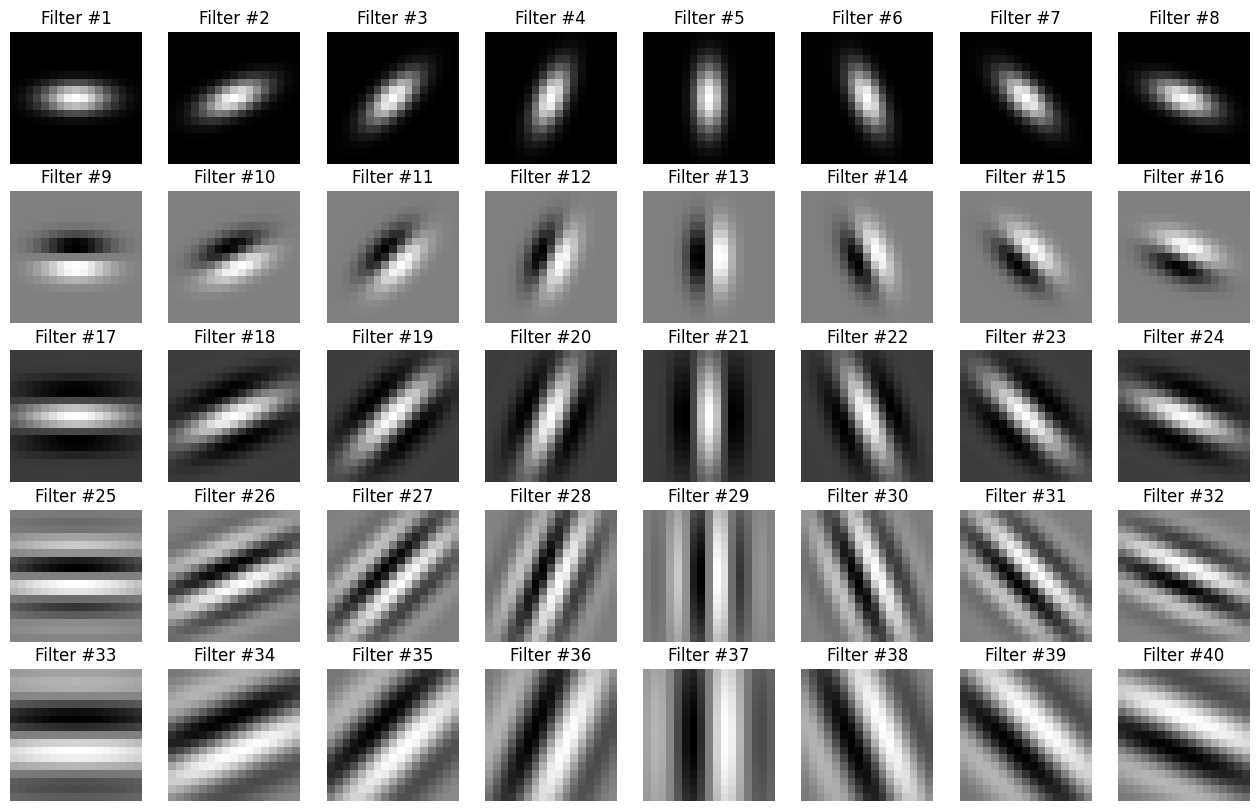

In [14]:
def gen_gabor_tensor():
  kernels = []
  for sigma, lambd, psi in GABOR_PARMS:
    for theta in range(GABOR_ORIENTATIONS):
        kernel = cv2.getGaborKernel((GABOR_SIZE,GABOR_SIZE), sigma=sigma, theta=theta / float(GABOR_ORIENTATIONS) * np.pi, lambd=lambd , gamma=0.5, psi=psi) #, ktype=cv2.CV_32F)
        kernels.append(kernel)
  kerneltensor = np.array(kernels)
  kerneltensorgray = np.moveaxis(kerneltensor, [0, 1, 2], [2, 1, 0])[:,:,np.newaxis,:]
  rows,cols,chans,nfs = kerneltensorgray.shape
  kerneltensorrgb = np.zeros((rows,cols,3,nfs*3))
  for i in range(nfs):
    for j in range(3):
      kerneltensorrgb[:,:,j,3*i+j] = kerneltensorgray[:,:,0,i]
  return kerneltensorgray, kerneltensorrgb

def plot_filters(kerneltensor):
  fig, axs = plt.subplots(NKGABOR//GABOR_ORIENTATIONS,GABOR_ORIENTATIONS, figsize=(2.0*GABOR_ORIENTATIONS,2.0*NKGABOR//GABOR_ORIENTATIONS))
  for i in range(NKGABOR):
    axs[i//GABOR_ORIENTATIONS,i%GABOR_ORIENTATIONS].imshow(kerneltensor[:,:,0,i], cmap="gray")
    axs[i//GABOR_ORIENTATIONS,i%GABOR_ORIENTATIONS].axis("off")
    axs[i//GABOR_ORIENTATIONS,i%GABOR_ORIENTATIONS].set_title(f"Filter #{i+1}")

kerneltensorgray, kerneltensorrgb = gen_gabor_tensor()
assert NKGABOR == kerneltensorgray.shape[-1]
plot_filters(kerneltensorgray)
print(f"Número total de filtros (kernels) de Gabor: {NKGABOR}\n"
      f"Forma del tensor de filtros de GABOR sobre imagen de grises: {kerneltensorgray.shape}\n"
      f"Forma del tensor de filtros de GABOR sobre imagen RGB: {kerneltensorrgb.shape}")

## Cómputo de vectores de características

### Modelo Keras para cómputo de vectores de características

Definimos un modelo con 4 capas de Keras para generar, a partir de cada parche de entrada, un vector de salida de tamaño 1960 (para parches de entrada tipo gray) o 5880 (para parches de tipo rgb). Lo haremos con un modelo de Keras porque es mucho más rápido computar todos los vectores para un conjunto grande de parches de una sola vez, usando un _batch_ con todos ellos. Computaremos así los vectores de características Gabor gray y Gabor RGB de una sola vez (_batch_) para cada conjunto (training, test, validación) de parches de entrada.

Obsérvese que en este caso, aunque usemos un modelo de Keras, fijaremos todos los pesos necesarios a priori (es decir, no será necesario realizar ningún entrenamiento sobre ellos; son características (_features_) de tipo _hand_engineered_):

In [15]:
def modelTileToGaborVector(gray = True):
  if gray:
    layerGaborGray = layers.Conv2D(kerneltensorgray.shape[-1], kernel_size=(GABOR_SIZE,GABOR_SIZE), strides=(1,1), padding='valid', use_bias=False, name="GaborGray")
    layerGaborGray.build((1,TS,TS,1))
    layerGaborGray.set_weights([kerneltensorgray])
  else:
    layerGaborRGB  = layers.Conv2D(kerneltensorrgb.shape[-1], kernel_size=(GABOR_SIZE,GABOR_SIZE), strides=(1,1), padding='valid', use_bias=False, name="GaborRGB")
    layerGaborRGB.build((1,TS,TS,3))
    layerGaborRGB.set_weights([kerneltensorrgb])
  return keras.Sequential([
        keras.Input(shape=(TS, TS, 1 if gray else 3), name="Input"),  # Input shape (None,40,40,3) para RGB, (None,40,40,1) para gray.
        layerGaborGray if gray else layerGaborRGB,                    # Shape (None,24,24,120) (el filtro 17x17, padding "valid", se "come" 8 píxeles por cada lado; y hay 120 filtros).
        layers.AveragePooling2D(pool_size=(2, 2), strides=(1,1),      # Shape (None,23,23,120) (el filtro average 2x2, stride 1x1, se "come" un píxel).
                                padding="valid", name="Average"),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(3,3),          # Shape (None,7,7,120) (el filtro maxpool 3x3, stride 3x3, hace la división entera 23/3x23/3 = 7x7).
                            padding="valid", name="MaxPool"),
        layers.Flatten(name="Flatten"),                               # Shape (None, 5880) (el efecto del flatten, 7x7x120=5880).
      ], name="modelGaborGray" if gray else "modelGaborRGB")

# Creamos un modelo para entrada de parches de gris, y otro para parches RGB
modelGaborGray = modelTileToGaborVector(gray = True)
modelGaborGray.summary()
print("\n\n")
modelGaborRGB = modelTileToGaborVector(gray = False)
modelGaborRGB.summary()

# Probamos el modelo con un parche de entrada, para comprobar la forma del tensor de
# salida. Nótese que para usar un modelo hay que pasarle un *batch* de ejemplos,
# aunque, como en este caso, sólo haya un ejemplo con el que llamar al modelo.
# Por ejemplo, para un parche RGB, la salida es un vector de 5880 componentes:
output = modelGaborRGB(np.array([tiles_train[0]]))
print(output.shape)
# Nota: El valor exacto de 5880 se puede deducir de las sucesivas transformaciones
#       sobre el tile de entrada que va haciendo cada capa del modelo:
assert output.shape[-1] == NKGABORRGB*(((TS-2*(GABOR_SIZE//2))-1)//3)**2

Model: "modelGaborGray"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ GaborGray (Conv2D)                   │ (None, 24, 24, 40)          │          11,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Average (AveragePooling2D)           │ (None, 23, 23, 40)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool (MaxPooling2D)               │ (None, 7, 7, 40)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten (Flatten)                    │ (None, 1960)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,560 (45.16 KB)

 Trainable params: 11,560 (45.16 KB)

 Non-trainable params: 0 (0.00 B)

Model: "modelGaborRGB"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ GaborRGB (Conv2D)                    │ (None, 24, 24, 120)         │         104,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Average (AveragePooling2D)           │ (None, 23, 23, 120)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool (MaxPooling2D)               │ (None, 7, 7, 120)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten (Flatten)                    │ (None, 5880)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 104,040 (406.41 KB)

 Trainable params: 104,040 (406.41 KB)

 Non-trainable params: 0 (0.00 B)

(1, 5880)


He aquí la imagen de la arquitectura de procesamiento de la red, en forma de "flujo de tensores" (de ahí, p.e., el nombre de TensorFlow):
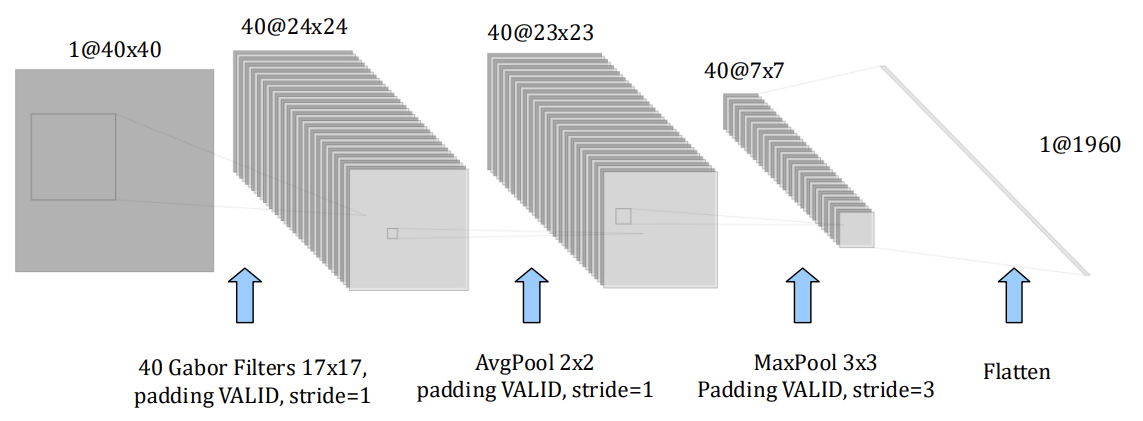

### Cómputo de datasets de características

Computamos ahora, para cada tile de entrada, cuatro vectores de características diferentes (formando así cuatro datasets diferentes en los que hacer pruebas de aprendizaje):
* Vector (parche aplanado) de niveles de gris.
* Vector (parche aplanado) RGB.
* Vector con características procesadas a partir de los filtros de Gabor para niveles de gris (salida del modelo `modelGaborGray`).
* Vector con características procesadas a partir de los filtros de Gabor para RGB (salida del modelo y `modelGaborRGB`).

In [16]:
%%time

def features(tiles, feat):
  if feat == "gray":
    return np.mean(tiles,axis=3).reshape(len(tiles),-1)
  elif feat == "rgb":
    return tiles.reshape(len(tiles),-1)
  elif feat == "gabor_gray":
    return modelGaborGray(np.mean(tiles,axis=3)).numpy()
  elif feat == "gabor_rgb":
    return modelGaborRGB(tiles).numpy()
  else:
    raise(ValueError(f"Incorrect extractor={extractor} parameter in features(...) function. Valid values: gray / rgb / gabor_gray / gabor_rgb"))

def compute_features_datasets(feat_types):
  X_train, X_test, X_val = {}, {}, {}
  for feat_type in feat_types:
    X_train[feat_type] = features(tiles_train, feat_type)
    X_test[feat_type] = features(tiles_test, feat_type)
    X_val[feat_type] = features(tiles_val, feat_type)
  return X_train, X_test, X_val

feat_types = ["gray", "rgb", "gabor_gray", "gabor_rgb"]
X_train, X_test, X_val = compute_features_datasets(feat_types)
print(f'Vectores gray:       train {X_train["gray"].shape}, test {X_test["gray"].shape}, val {X_val["gray"].shape}\n'
      f'Vectores RGB:        train {X_train["rgb"].shape}, test {X_test["rgb"].shape}, val {X_val["rgb"].shape}\n'
      f'Vectores Gabor gray: train {X_train["gabor_gray"].shape}, test {X_test["gabor_gray"].shape}, val {X_val["gabor_gray"].shape}\n'
      f'Vectores Gabor RGB:  train {X_train["gabor_rgb"].shape}, test {X_test["gabor_rgb"].shape}, val {X_val["gabor_rgb"].shape}')

Vectores gray:       train (9600, 1600), test (1200, 1600), val (1200, 1600)
Vectores RGB:        train (9600, 4800), test (1200, 4800), val (1200, 4800)
Vectores Gabor gray: train (9600, 1960), test (1200, 1960), val (1200, 1960)
Vectores Gabor RGB:  train (9600, 5880), test (1200, 5880), val (1200, 5880)
CPU times: user 54.8 s, sys: 7.8 s, total: 1min 2s
Wall time: 38.5 s


### Visualización de vectores de características

Dibujamos los cuatro tipos de vectores de características (en este caso, unos cuantos escogidos aleatoriamente del conjunto de training):

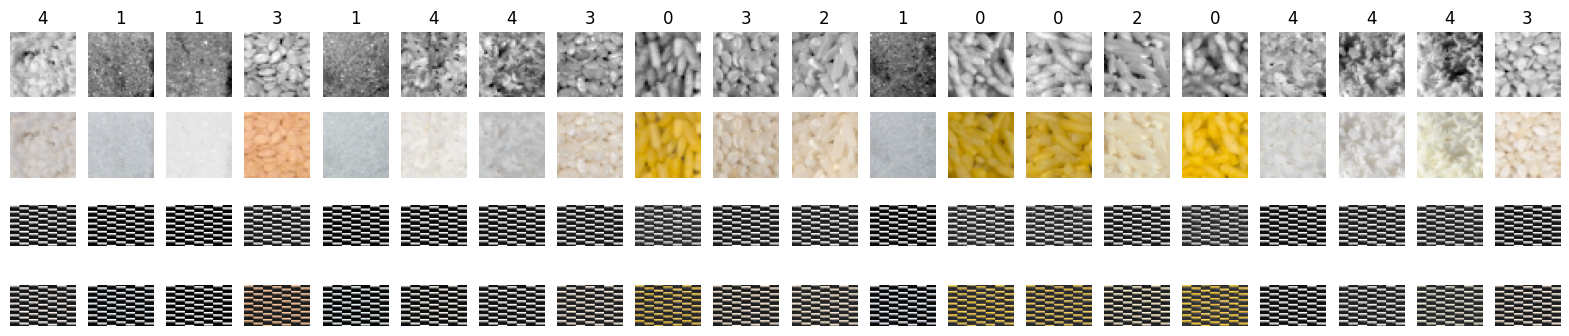

In [17]:
def plot_feature_vectors(X_train, labels_train, feat_types, nsamples_to_show=20, random_state=50):
  # En primer lugar, mezclamos los vectores:
  X_shuffled, labels_shuffled = {}, {}
  for feat_type in feat_types:
    # Fijamos random_state a un número fijo cualquiera, para que todas las mezclas se realicen igual:
    X_shuffled[feat_type], labels_shuffled[feat_type] = shuffle(X_train[feat_type], labels_train, random_state=random_state)
  fig, axs, = plt.subplots(4, nsamples_to_show, figsize=(nsamples_to_show,4))
  for i, feat_type in enumerate(["gray","rgb","gabor_gray", "gabor_rgb"]):
    for j, (vec, lab) in enumerate(zip(X_shuffled[feat_type][:nsamples_to_show], labels_shuffled[feat_type][:nsamples_to_show])):
      if feat_type == "gray":
        axs[i,j].set_title(f"{lab}")
        axs[i,j].imshow(vec.reshape(TS,TS),cmap="gray")
      elif feat_type == "rgb":
        axs[i,j].imshow(vec.reshape(TS,TS,3))
      elif feat_type == "gabor_gray":
        axs[i,j].imshow(vec.reshape(7*len(GABOR_PARMS),7*GABOR_ORIENTATIONS), cmap="gray")
      elif feat_type == "gabor_rgb":
        img_gab_rgb = vec.reshape(7*len(GABOR_PARMS),7*GABOR_ORIENTATIONS,3)
        axs[i,j].imshow((img_gab_rgb-np.min(img_gab_rgb))/(np.max(img_gab_rgb)-np.min(img_gab_rgb)))
      axs[i,j].axis("off")

plot_feature_vectors(X_train, labels_train, feat_types, nsamples_to_show=20, random_state=50)

En realidad, las features de Gabor anteriores no se han visualizado demasiado intuitivamente. Para intentar presentar algo más intuitivo, mostraremos aquí los NKGABOR canales de salida (en este caso, sólo para el primer elemento de training de cada clase, y sólo para la salida de los filtros de Gabor de la imagen de grises). Obsérvense los efectos más aparentes de los promediados (capa average) y el filtro no lineal de máximo (capa max pool):

CPU times: user 3.94 s, sys: 26.8 ms, total: 3.96 s
Wall time: 4.11 s


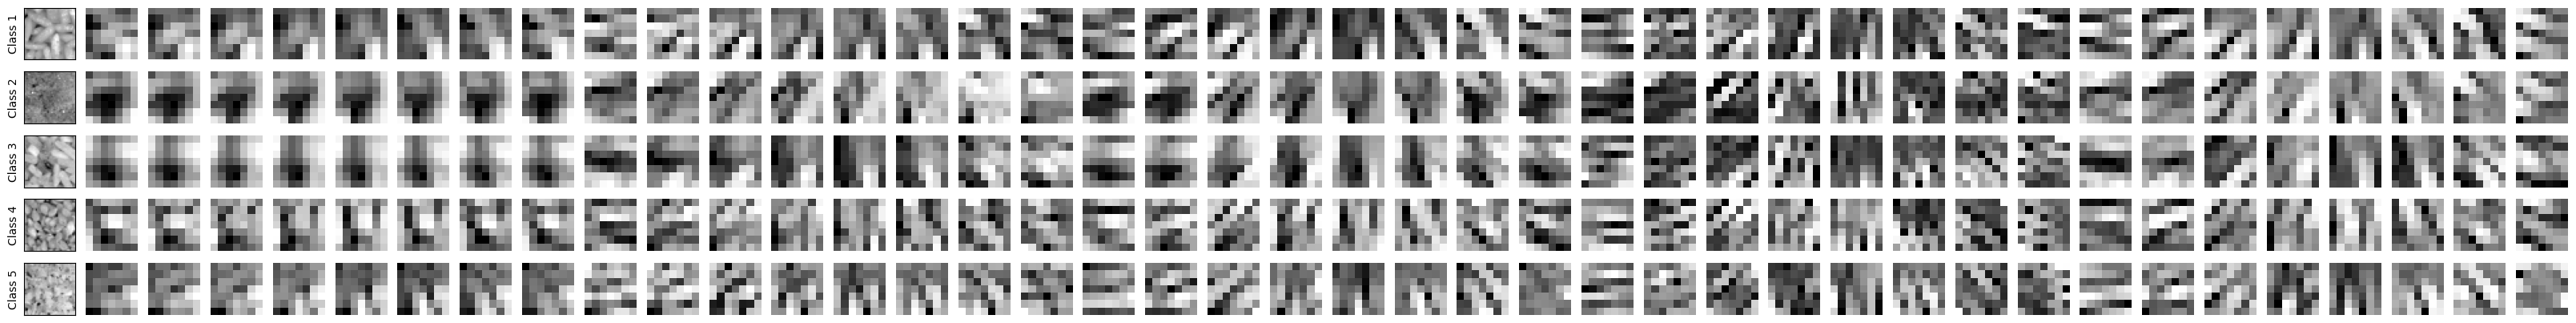

In [18]:
%%time

def plot_gabor_gray_features(X_train, labels_train):
  fig, axs = plt.subplots(NC, NKGABOR+1, figsize=(NKGABOR+1, NC))
  for r in range(NC):
    ind = list(labels_train).index(r)
    axs[r,0].imshow(X_train["gray"][ind].reshape(TS,TS), cmap="gray")
    axs[r,0].set_xticks([])
    axs[r,0].set_yticks([])
    axs[r,0].set_ylabel(f"Class {r+1}")
    gab_result = X_train["gabor_gray"][ind].reshape(7,7,40)
    for c in range(NKGABOR):
      axs[r,c+1].imshow(gab_result[:,:,c], cmap="gray")
      axs[r,c+1].axis("off")

plot_gabor_gray_features(X_train, labels_train)

## Entrenamiento de un regresor logístico con sklearn

Entrenamos cuatro clasificadores sencillos (regresores logísticos multiclase de sklearn), con los cuatro datasets de _hand engineered features_:

In [19]:
%%time

# Decorador python en realidad innecesario (es sólo para evitar algunos mensajes de warning no informativos)
@ignore_warnings(category=ConvergenceWarning)
def compute_sklearn_classifiers(feat_types):
  classifiers = {}
  for feat_type in feat_types:
    print(f"Computing classifier for {feat_type} features...", end="")
    classifiers[feat_type] = make_pipeline(StandardScaler(),  LogisticRegression(penalty="l2", solver="sag", max_iter=30)) # Alternativas: solver="lbfgs" | solver="liblinear",
    classifiers[feat_type].fit(X_train[feat_type], labels_train)
    print(" Done!")
  return classifiers

classifiers = compute_sklearn_classifiers(feat_types)
# print(classifiers)

Computing classifier for gray features... Done!
Computing classifier for rgb features... Done!
Computing classifier for gabor_gray features... Done!
Computing classifier for gabor_rgb features... Done!
CPU times: user 1min 52s, sys: 427 ms, total: 1min 52s
Wall time: 1min 56s


Y mostramos sus resultados tanto sobre el conjunto de training como sobre el de test:


                                                                                                           Results on training set
              precision    recall  f1-score   support                  precision    recall  f1-score   support                  precision    recall  f1-score   support                  precision    recall  f1-score   support
            
           0       0.93      1.00      0.96      1920               0       1.00      1.00      1.00      1920               0       0.96      0.99      0.98      1920               0       1.00      1.00      1.00      1920
           1       0.71      0.65      0.68      1920               1       0.84      0.86      0.85      1920               1       0.87      0.96      0.92      1920               1       0.94      1.00      0.96      1920
           2       0.81      0.79      0.80      1920               2       0.84      0.92      0.88      1920               2       0.88      0.84      0.86      1920             

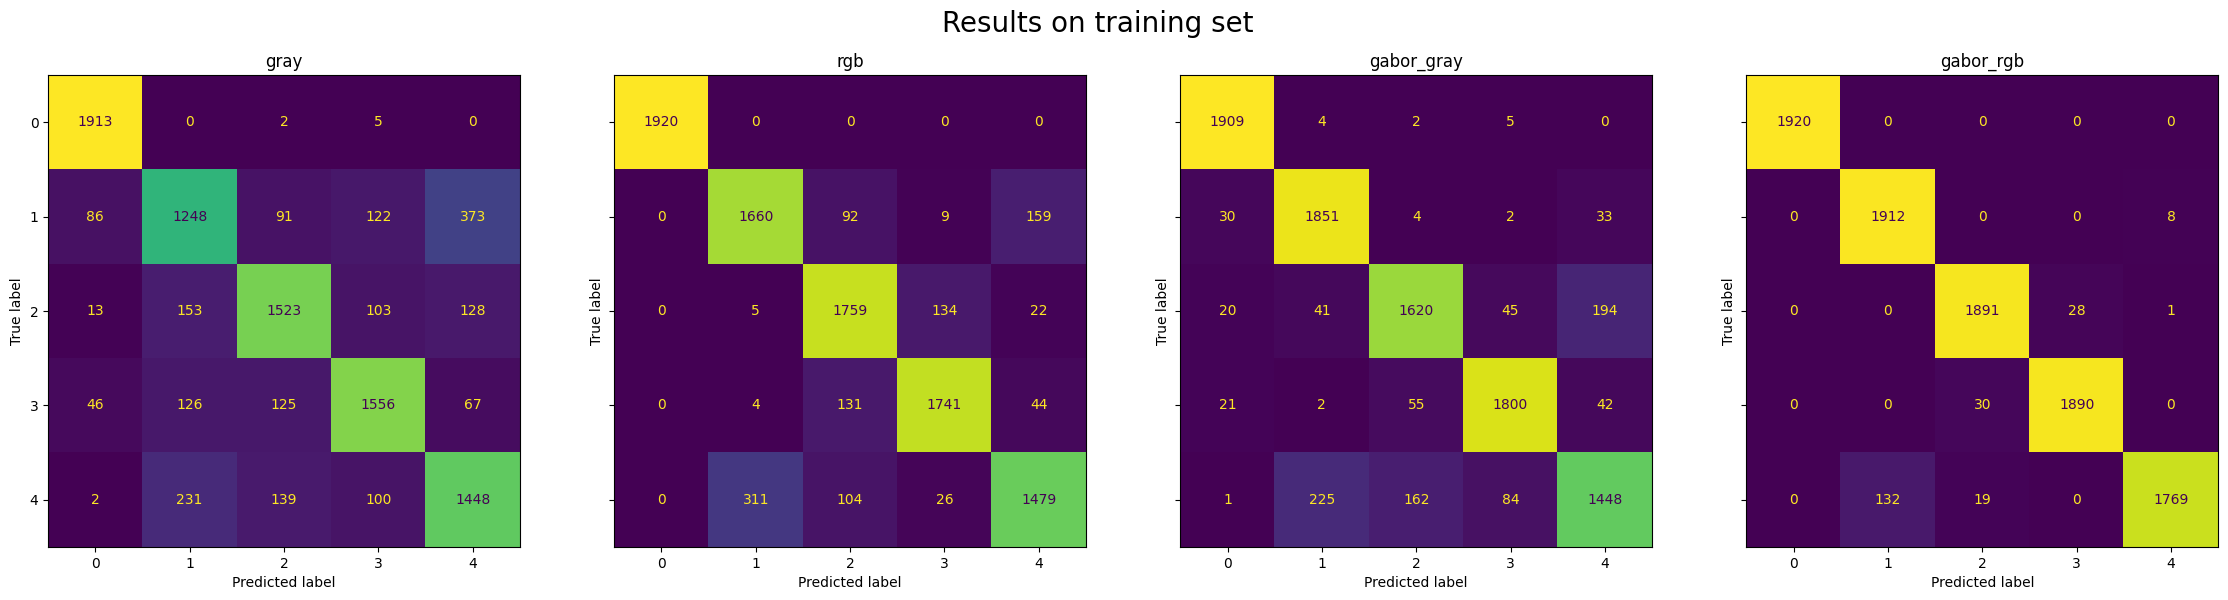

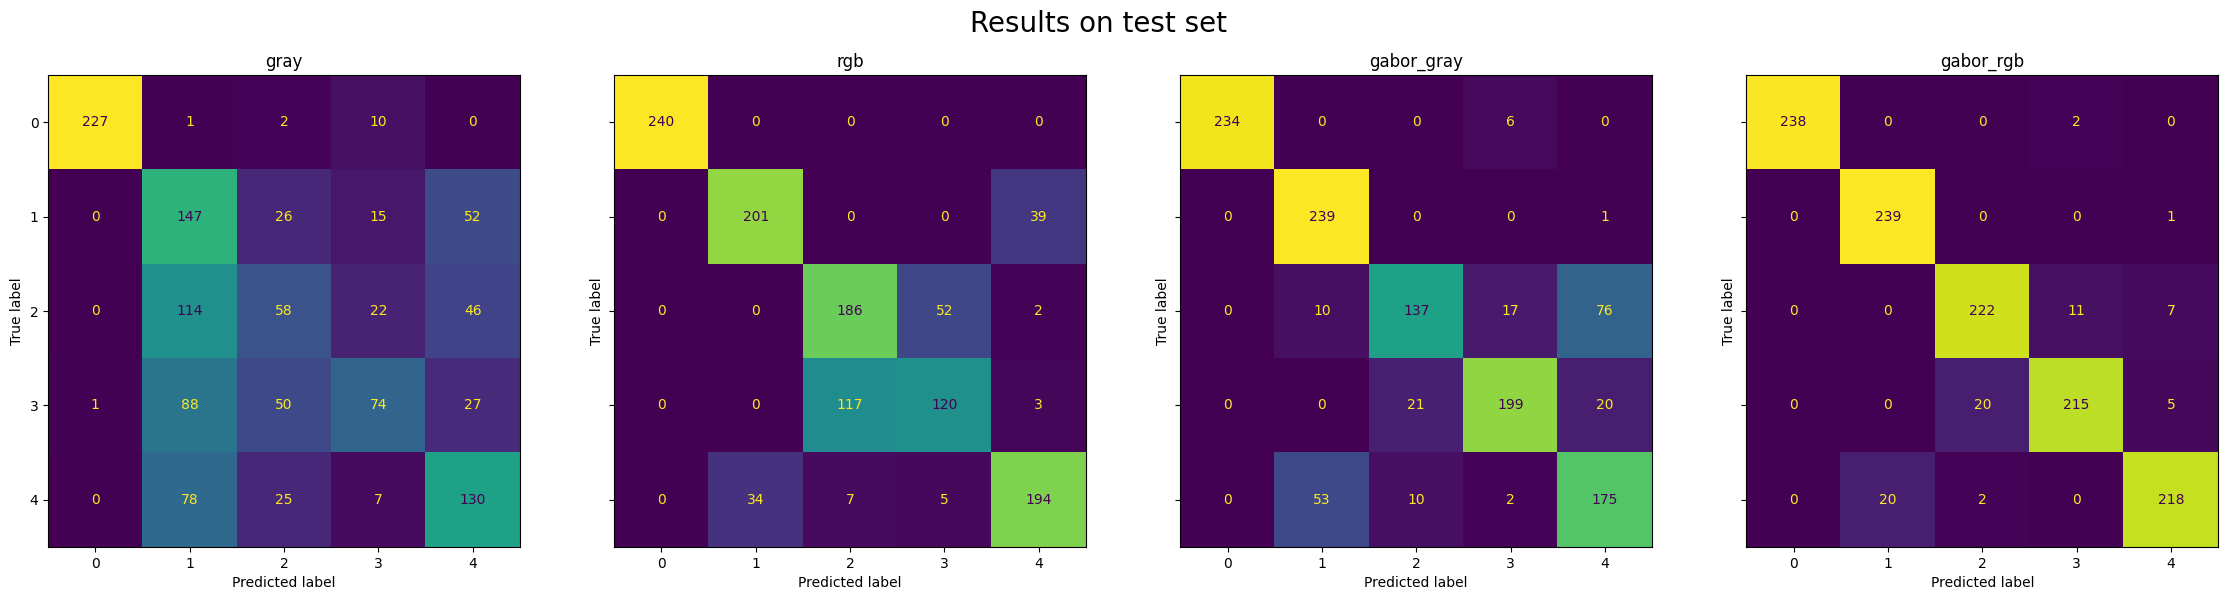

In [20]:
def show_classifiers_results(feat_types, classifiers, X_train, X_test, labels_train, labels_test):
  # Usamos los clasificadores entrenados para predecir tanto en el conjunto de
  # train como en el de test:
  labels_train_pred, labels_test_pred = {}, {}
  for feat in feat_types:
    labels_train_pred[feat] = classifiers[feat].predict(X_train[feat])
    labels_test_pred[feat] = classifiers[feat].predict(X_test[feat])

  # Y mostramos los resultados (tanto el resumen de precision/recall por clase,
  # como la matriz de confusión, para ambos casos, training y test):
  for labels, labels_pred, title in zip([labels_train,labels_test], [labels_train_pred, labels_test_pred], ["Results on training set", "Results on test set"]):
    fig, axs = plt.subplots(1, len(feat_types), figsize=(28, 7), sharey='row')
    for i, feat in enumerate(feat_types):
      cf_matrix = confusion_matrix(labels, labels_pred[feat])
      disp = ConfusionMatrixDisplay(cf_matrix)
      disp.plot(ax=axs[i])
      disp.ax_.set_title(feat)
      disp.im_.colorbar.remove()
      fig.suptitle(title, fontsize=20, y=0.925)

    print(f"\n{title:>130}")
    print(f"{len(title)*'=':>130}")
    for i,line in enumerate(zip(*[classification_report(labels, labels_pred[feat]).split("\n") for feat in feat_types])):
      print(line[0] + "    " + line[1] + "    " + line[2] + "    " + line[3])

show_classifiers_results(feat_types, classifiers, X_train, X_test, labels_train, labels_test)

### Conclusiones del estudio de clasificadores _hand engineered_

Pueden extraerse varias conclusiones:
* Aunque los clasificadores ajustan relativamente bien los datos de training (85%-99% acierto, excepto el de grises, que sólo llega a un menor ~70%-75%), en realidad no todos están generalizando bien (los resultados empeoran bastante con los tests, especialmente en las versiones que trabajan con imágenes de gris, aunque en menor medida si se usan los filtros de Gabor).
* En general, a mayor número de _features_ extraídas, y a mayor sofisticación (Gabor mejor que vectores sacados de hacer un simple _"flatten"_ del parche), mejor rendimiento (medido ya sobre el conjunto de test): gabor_rgb > rgb > gabor_gray > gray.
* El mejor clasificador es, por tanto, gabor_rgb, con un rendimiento en test de alrededor del ~94%-96%.
* De las matrices de confusión se deduce fácilmente que las clases 2 y 3 son las que más confunden a los modelos aprendidos (lo cual tiene toda la lógica, ya que son las más parecidas visualmente entre sí).

**Nota**: Todos los porcentajes comentados pueden obviamente variar al cambiar las condiciones de tratamiento del dataset (tamaño del parche, stride, etc.), aunque, cualitativamente, salvo cambios drásticos en estos parámetros, se deberían seguir observando las tendencias comentadas.

## Segmentación de una imagen con una FCNN

**Nota:** Dadas las conclusiones obtenidas en el apartado anterior, a partir de este momento trabajaremos solamente usando el esquema de extracción de características más potente, esto es, el esquema `gabor_rgb`.

En este apartado vamos a construir una capa adicional que añadiremos al modelo de Keras que antes sólo realizaba la extracción de características (_backbone_) para que, añadiendo el classificador entrenado, realice una clasificación completa (esto es, decida, para cada parche de entrada, las probabilidades de que se trate de cualquiera de las 9 clases de textura).



Para ello, en primer lugar extraeremos los vectores de media y escalado del primer elemento del pipeline del clasificador sklearn (StandardScaler, que normaliza los vectores de entrada), y a continuación hacemos lo propio con los coeficientes y el bias del segundo elemento del pipeline (regresor logístico).



In [21]:
mean = classifiers["gabor_rgb"]["standardscaler"].mean_
scale = classifiers["gabor_rgb"]["standardscaler"].scale_
coef = classifiers["gabor_rgb"]["logisticregression"].coef_
intercept = classifiers["gabor_rgb"]["logisticregression"].intercept_

# Imprimimos las formas de los valores extraídos:
print(f"mean vector:      {mean.shape}\n"
      f"scale vector:     {scale.shape}\n"
      f"coef vector:      {coef.shape}\n"
      f"intercept vector: {intercept.shape}")

# Comprobación de corrección:
assert mean.shape[-1] == scale.shape[-1] == coef.shape[-1] == NKGABORRGB *(((TS-2*(GABOR_SIZE//2))-1)//3)**2
assert coef.shape[0] == intercept.shape[0] == NC

mean vector:      (5880,)
scale vector:     (5880,)
coef vector:      (5, 5880)
intercept vector: (5,)


Adaptamos ahora los valores anteriores a la forma adecuada de los tensores para que encajen en la última capa (capa de clasificación) de nuestro nuevo modelo convolucional. Obsérvese que nuestra intención es, en este caso, hacer el modelo ya directamente _fully convolutional_ (esto es, que pueda realizarse la inferencia sobre imágenes completas de cualquier tamaño, no solamente parches de 40x40):

In [22]:
# Hacemos los correspondientes "reshapes", para adaptarnos a la salida de las capa
# final del modelo anterior de extracción de características:
OUT_TENSOR_R = OUT_TENSOR_C = ((TS-2*(GABOR_SIZE//2))-1)//3
assert OUT_TENSOR_R == OUT_TENSOR_C == int(math.sqrt(len(mean)//NKGABORRGB))
mean_tensor = mean.reshape(OUT_TENSOR_R,OUT_TENSOR_C,NKGABORRGB,1)
scale_tensor = scale.reshape(OUT_TENSOR_R,OUT_TENSOR_C,NKGABORRGB,1)
coef_tensor = coef.reshape(5,OUT_TENSOR_R,OUT_TENSOR_C,NKGABORRGB)  # El 9 debería ser 5? (cambiado ya por 5)
coef_tensor = np.moveaxis(coef_tensor,[0,1,2,3],[3,0,1,2])
print(f"mean tensor:      {mean_tensor.shape}\n"
      f"scale tensor:     {scale_tensor.shape}\n"
      f"coef tensor:      {coef_tensor.shape}\n"
      f"intercept vector: {intercept.shape}")

mean tensor:      (7, 7, 120, 1)
scale tensor:     (7, 7, 120, 1)
coef tensor:      (7, 7, 120, 5)
intercept vector: (5,)


Transferimos ahora el efecto de la escala (scale_tensor) y la media (mean_tensor) de la primera etapa del pipeline de sklearn a los valores del clasificador de la segunda etapa (coef_tensor e intercept), para obtener ya simplemente dos tensores (coef_norm e intercept_norm) con los que construiremos la última capa del modelo:



In [23]:
# Los pesos nuevos no son más que los pesos del clasificador convenientemente escalados por el factor de escalado
# de la entrada...
coef_norm = coef_tensor/scale_tensor
# ... si bien para los bias hay que hacer una pequeña cuenta, derivable si se hace el correspondiente desarrollo
# algebraico:
intercept_norm = -coef_tensor.reshape(-1,5).T @ (mean_tensor/scale_tensor).reshape(-1,1).flatten() + intercept    # Cambiamos el 9 por un 5
print(f"coef_norm tensor:      {coef_norm.shape}\n"
      f"intercept_norm vector: {intercept_norm.shape}")

coef_norm tensor:      (7, 7, 120, 5)
intercept_norm vector: (5,)


Finalmente, construimos con los pesos anteriores la capa final de clasificación, y con ella el nuevo modelo (que, recuérdese, es ya _fully convolutional_, y por tanto puede probarse con imágenes completas en lugar de con parches sueltos):

In [24]:
def build_modelFCNN():
  layerClf = layers.Conv2D(NC, kernel_size=(OUT_TENSOR_R,OUT_TENSOR_C), strides=(1,1), padding='valid', use_bias=True, activation="softmax", name="classifier")
  layerClf.build((1,H,W,120))
  layerClf.set_weights([coef_norm, intercept_norm])

  layerGaborRGB = layers.Conv2D(kerneltensorrgb.shape[-1], kernel_size=(GABOR_SIZE,GABOR_SIZE), strides=(1,1), padding='valid', use_bias=False, name="GaborRGB")
  layerGaborRGB.build((1,TS,TS,3))
  layerGaborRGB.set_weights([kerneltensorrgb])

  return keras.Sequential([
      keras.Input(shape=(None, None, 3), name="Input"),
      layerGaborRGB,
      layers.AveragePooling2D(pool_size=(2, 2), strides=(1,1), padding="valid", name="Average"),
      layers.MaxPooling2D(pool_size=(3, 3), strides=(3,3), padding="valid", name="MaxPool"),
      layerClf,
    ], name="modelFCNN")

modelFCNN = build_modelFCNN()
modelFCNN.summary()

Model: "modelFCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ GaborRGB (Conv2D)                    │ (None, None, None, 120)     │         104,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Average (AveragePooling2D)           │ (None, None, None, 120)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool (MaxPooling2D)               │ (None, None, None, 120)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classifier (Conv2D)                  │ (None, None, None, 5)       │          29,405 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 133,445 (521.27 KB)

 Trainable params: 133,445 (521.27 KB)

 Non-trainable params: 0 (0.00 B)

El número de parámetros de la capa de clasificación final no es más que el resultado de multiplicar el tamaño del vector de entrada por el número de clases (matriz de pesos W de la capa) y sumar un _bias_ por cada clase, es decir:

5880*9+9=52929

He aquí también un esquema de la arquitectura de la red, modificada respecto a la básica, para obtener una versión _fully convolutional_, FCNN:

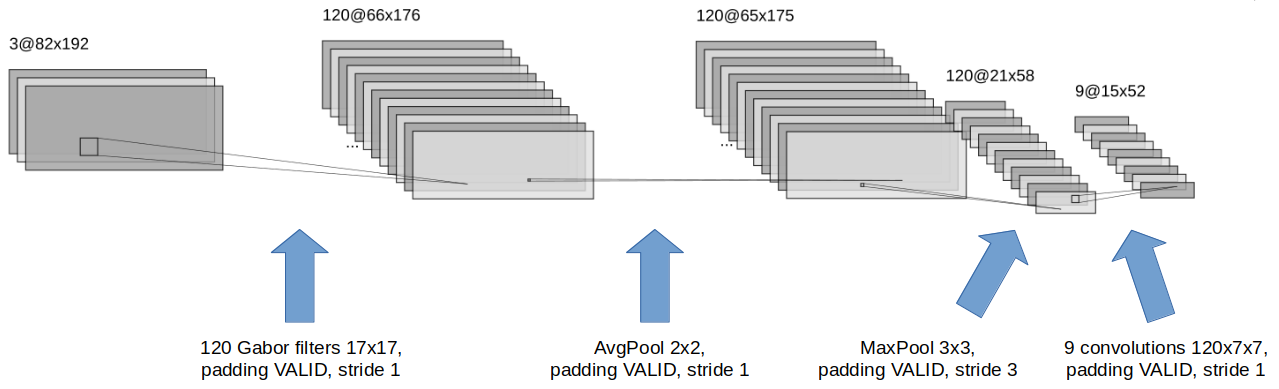

Construimos ahora una imagen para testear el modelo de segmentación construido:

(82, 960, 3)


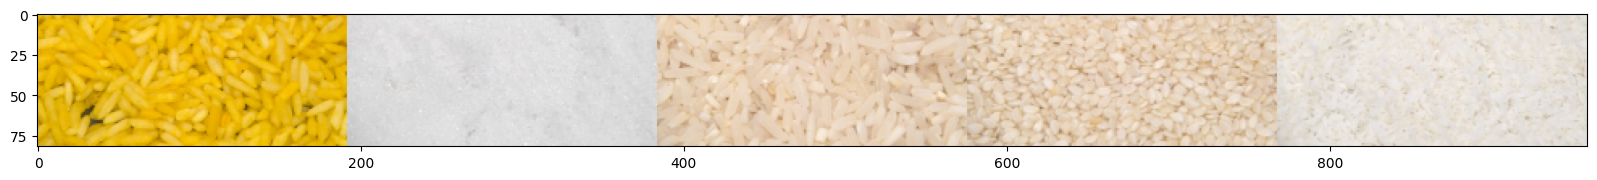

In [25]:
def build_test_image_all_classes(ind_example):
  assert ind_example < NIS_TEST # Nos aseguramos de testear con imágenes no vistas durante el entrenamiento.
  imgtest = np.concatenate([imgsclass[-(ind_example+1)][:,:] for imgsclass in imgs],axis=1)
  return imgtest

imgtest = build_test_image_all_classes(2)
plt.figure(figsize=(20.0,NC*20.0))
plt.imshow(imgtest)
print(imgtest.shape)

Finalmente, probamos nuestro modelo FCNN con dicha imagen, dibujando, por cada canal de salida, una imagen de segmentación resultado. En condiciones ideales, las segmentaciones ideales deberían dibujar un resultado completamente diagonal, y las desviaciones frente a este muestran visualmente los casos de fallo:

Forma del tensor con el batch de entrada: (82, 960, 3)
Forma del tensor con el batch de salida: (1, 15, 308, 5)



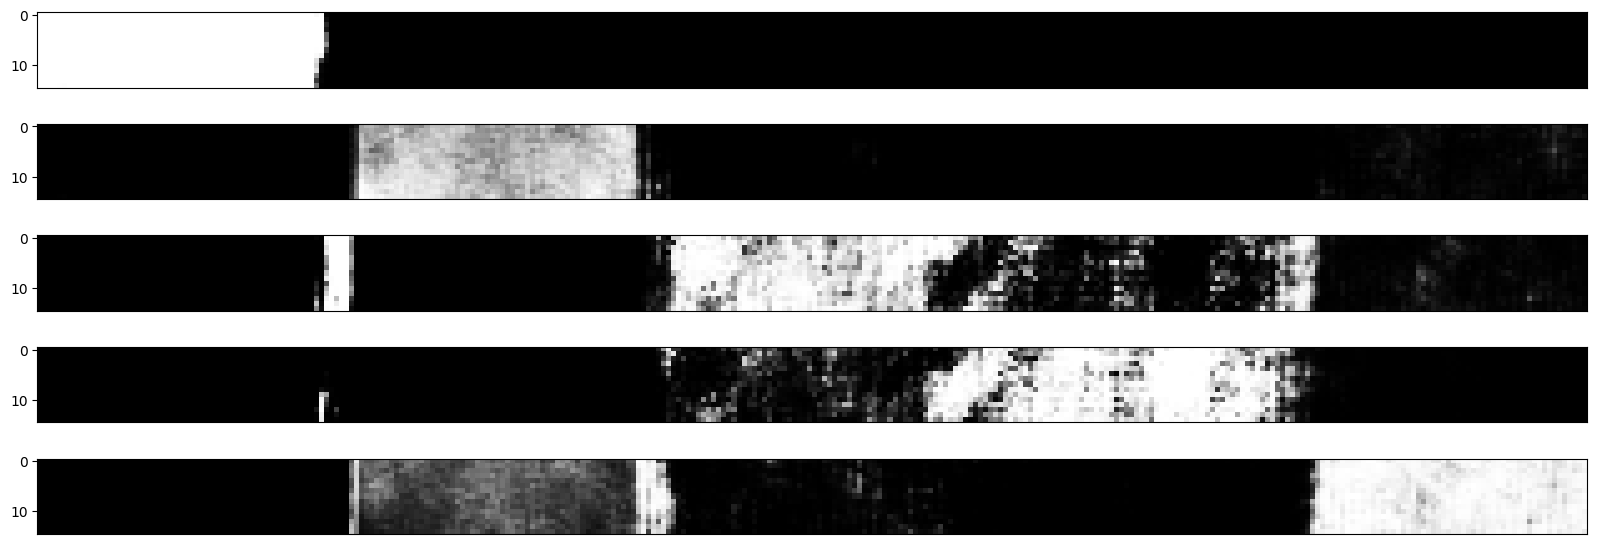

In [26]:
input_batch = np.array([imgtest])
output_tensor = modelFCNN(input_batch)
print(f"Forma del tensor con el batch de entrada: {imgtest.shape}\n"
      f"Forma del tensor con el batch de salida: {output_tensor.shape}\n")
fig, axs = plt.subplots(NC, 1, figsize=(20.0,7.0))
for i in range(NC):
  axs[i].imshow(output_tensor[0,:,:,i], cmap="gray")
  axs[i].set_xticks([])

Comprobamos también ahora que, efectivamente, si aplicamos la red FCNN a una imagen de entrada, de dimensión 82x192, obtenemos un tensor de salida de 15x52x9, tal y como razonamos en el esquema de la red FCNN anterior:

Forma del tensor con el batch de entrada: (1, 82, 192, 3)
Forma del tensor con el batch de salida: (1, 15, 52, 5)



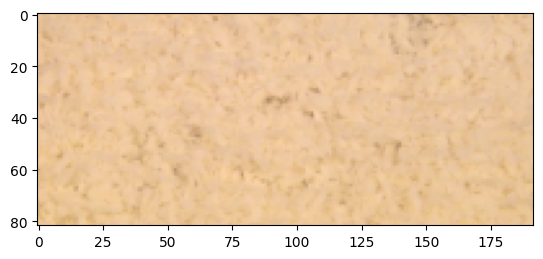

In [27]:
single_img_test= imgs[4][0]                 # [6] ---> [4]
input_batch = np.array([single_img_test])
output_tensor = modelFCNN(input_batch)
print(f"Forma del tensor con el batch de entrada: {input_batch.shape}\n"
      f"Forma del tensor con el batch de salida: {output_tensor.shape}\n")
plt.imshow(single_img_test);

He aquí también dibujado, por _slices_, el correspondiente tensor de salida para dicha imagen (que, recordemos, se corresponde con una instancia de la clase 5):

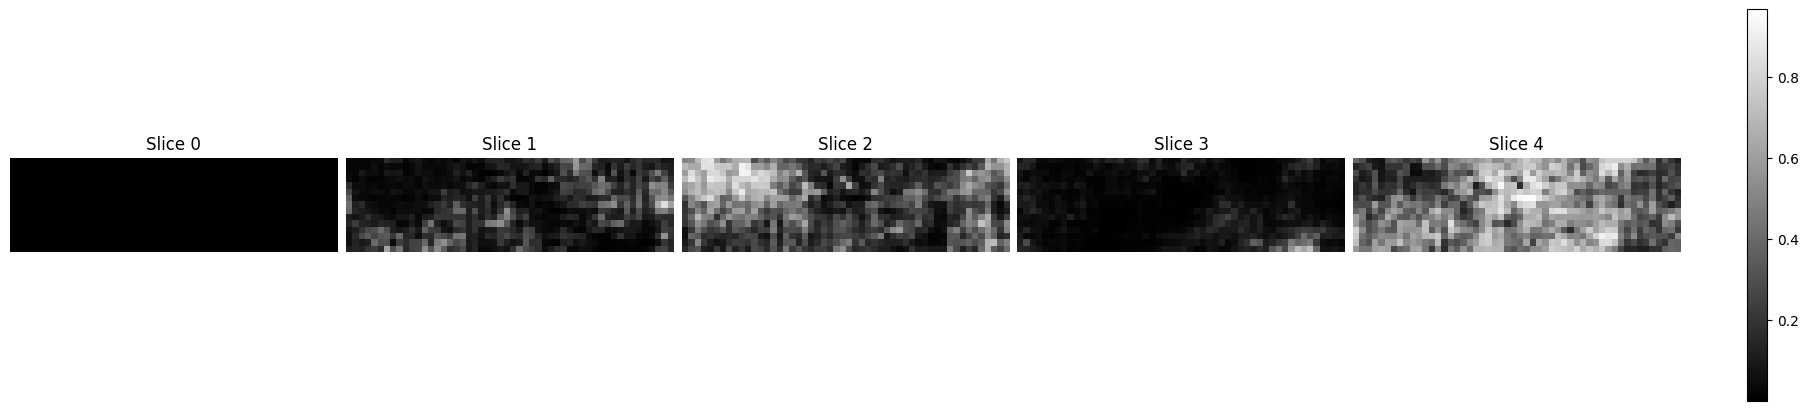

In [28]:
# Crear la figura y los ejes
fig, axes = plt.subplots(1, 5, figsize=(18, 4), constrained_layout=True)

# Determinar el rango común para la barra de color
vmin, vmax = output_tensor.numpy().min(), output_tensor.numpy().max()

# Mostrar cada slice en escala de grises
for i in range(5):
    im = axes[i].imshow(output_tensor[0,:, :, i], cmap='gray', vmin=vmin, vmax=vmax)
    axes[i].set_title(f'Slice {i}')
    axes[i].axis('off')  # Ocultar los ejes

# Agregar una barra de color común
fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)

plt.show()

### Intento de mejorar vía gradiente descendente el modelo

Partimos ahora del modelo obtenido, con sus pesos iniciales, pero liberando sus parámetros y ejecutando una optimización vía gradiente descendente, a ver si logramos mejorarlo. En primer lugar, creamos un nuevo modelo con salida única (_flatten_), para evaluarlo entonces sobre el train, el test y la validación, donde deberíamos obtener unos valores similares a los obtenidos anteriormente con `sklearn`:

In [29]:
%%time

# Creamos nuevo modelo (modelFCNNfree):
input_shape = (TS, TS, 3)
inputs = keras.layers.Input(shape=input_shape)
x = modelFCNN(inputs)
outputs = keras.layers.Flatten()(x)
modelFCNNfree = keras.models.Model(inputs=inputs, outputs=outputs)

# Imprimimos la forma de la salida (simple vector de 9 elementos = probabilidades de las clases):
print(modelFCNNfree(np.array([tiles_train[0]])).shape)

# Evaluamos el modelo ANTES de hacer un ajuste fino sobre él:
modelFCNNfree.set_weights(modelFCNN.get_weights())
modelFCNNfree.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(learning_rate=0.000001), metrics=["sparse_categorical_accuracy"])
print("Training evaluation:")
modelFCNNfree.evaluate(x=tiles_train,y=labels_train, batch_size=128)
print("Validation evaluation:")
modelFCNNfree.evaluate(x=tiles_val,y=labels_val, batch_size=128)
print("Test evaluation:")
modelFCNNfree.evaluate(x=tiles_test,y=labels_test, batch_size=128)

(1, 5)
Training evaluation:
75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 314ms/step - loss: 0.0543 - sparse_categorical_accuracy: 0.9938
Validation evaluation:
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - loss: 0.2026 - sparse_categorical_accuracy: 0.9432
Test evaluation:
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 397ms/step - loss: 0.1042 - sparse_categorical_accuracy: 0.9693
CPU times: user 46.5 s, sys: 4.15 s, total: 50.7 s
Wall time: 51.9 s


[0.16748493909835815, 0.9433333277702332]

Una vez comprobada la corrección del modelo, procedemos a ajustarlo (_fine-tuning_) entrenándolo partiendo de los pesos originales, y aplicando un gradiente descendiente con un _learning rate_ pequeño.

**Nota:** Si pensamos que usando un learning rate mayor podríamos mejorar los resultados, estamos equivocados; se puede comprobar que para _learning rate_ mayores no sólo no obtenemos mejores resultados, sino que incluso podemos hacer diverger al modelo.

In [30]:
%%time

# Copiamos los pesos del modelo original...
modelFCNNfree.set_weights(modelFCNN.get_weights())
# ... decidimos qué capas queremos reentrenar ...
modelFCNNfree.get_layer("modelFCNN").get_layer('GaborRGB').trainable = True
modelFCNNfree.get_layer("modelFCNN").get_layer('classifier').trainable = True
# ... y finalmente reentrenamos (fine-tuning):
modelFCNNfree.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), metrics=["sparse_categorical_accuracy"])
history = modelFCNNfree.fit(x=tiles_train, y=labels_train, validation_data=(tiles_val,labels_val), batch_size=64, epochs=10)

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 70s 461ms/step - loss: 0.1162 - sparse_categorical_accuracy: 0.9693 - val_loss: 0.2865 - val_sparse_categorical_accuracy: 0.9050
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 81s 457ms/step - loss: 0.1065 - sparse_categorical_accuracy: 0.9754 - val_loss: 0.2420 - val_sparse_categorical_accuracy: 0.9258
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 81s 451ms/step - loss: 0.0948 - sparse_categorical_accuracy: 0.9785 - val_loss: 0.3361 - val_sparse_categorical_accuracy: 0.8967
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 81s 448ms/step - loss: 0.1048 - sparse_categorical_accuracy: 0.9744 - val_loss: 0.2373 - val_sparse_categorical_accuracy: 0.9283
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 67s 447ms/step - loss: 0.0998 - sparse_categorical_accuracy: 0.9722 - val_loss: 0.2667 - val_sparse_categorical_accuracy: 0.9158
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 84s 464ms/step - loss: 0.0993 - sparse_categorical_accuracy: 0.9745 - val_loss: 0.2467 - val_sparse_categorical_acc

Se comprueba que, tras unas cuantas épocas, el proceso no logra optimizar más los resultados: tanto la pérdida (_loss_) como la precisión (_accuracy_) se estancan desde el principio en el proceso de entrenamiento.

Ahora evaluamos el modelo ajustado, comprobando que no se mejoran los resultados; el modelo carece de la profundidad necesaria para generar mejores características intermedias, y parece tener un tope de rendimiento en validación de alrededor de, como mucho, 94%-95%:

In [31]:
%%time

modelFCNNfree.evaluate(x=tiles_train,y=labels_train, batch_size=64)
modelFCNNfree.evaluate(x=tiles_val,y=labels_val, batch_size=64)
modelFCNNfree.evaluate(x=tiles_test,y=labels_test, batch_size=64)

150/150 ━━━━━━━━━━━━━━━━━━━━ 24s 163ms/step - loss: 0.0510 - sparse_categorical_accuracy: 0.9903
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - loss: 0.1849 - sparse_categorical_accuracy: 0.9381
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 0.0818 - sparse_categorical_accuracy: 0.9782
CPU times: user 46.5 s, sys: 475 ms, total: 46.9 s
Wall time: 46.4 s


[0.1554669886827469, 0.9508333206176758]

Comparemos visualmente los pesos originales con los modificados por el proceso de aprendizaje. Vemos que, aunque ciertamente dicho proceso ha modificado apreciablemente muchos de esos pesos, no ha logrado mejorar los resultados, debido fundamentalmente a la falta de profundidad de la red.

**Nota:** En realidad, por simplicidad, mostramos aquí sólo uno de los tres canales RGB, para comparar directamente con los filtros de Gabor monocanal.

Pesos antes del aprendizaje:


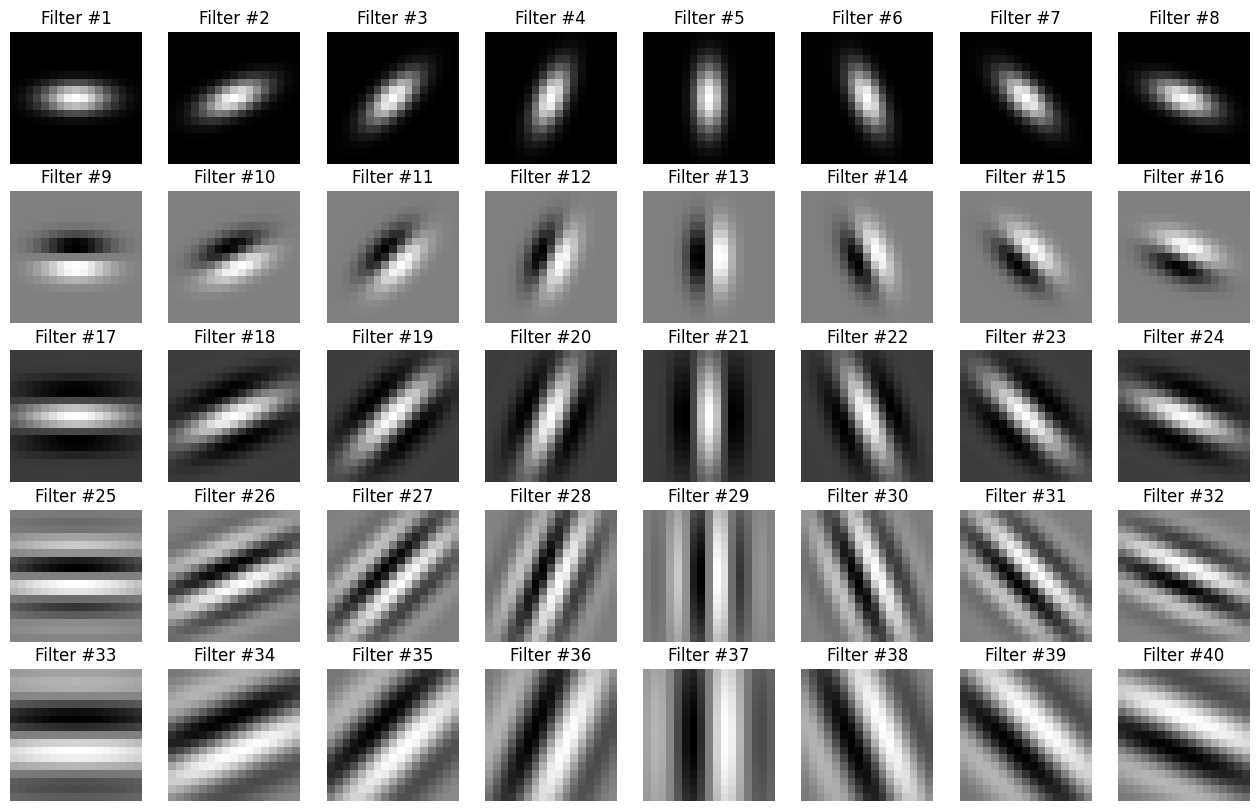

In [32]:
plot_filters(kerneltensorgray)
print("Pesos antes del aprendizaje:")

Pesos tras el aprendizaje:


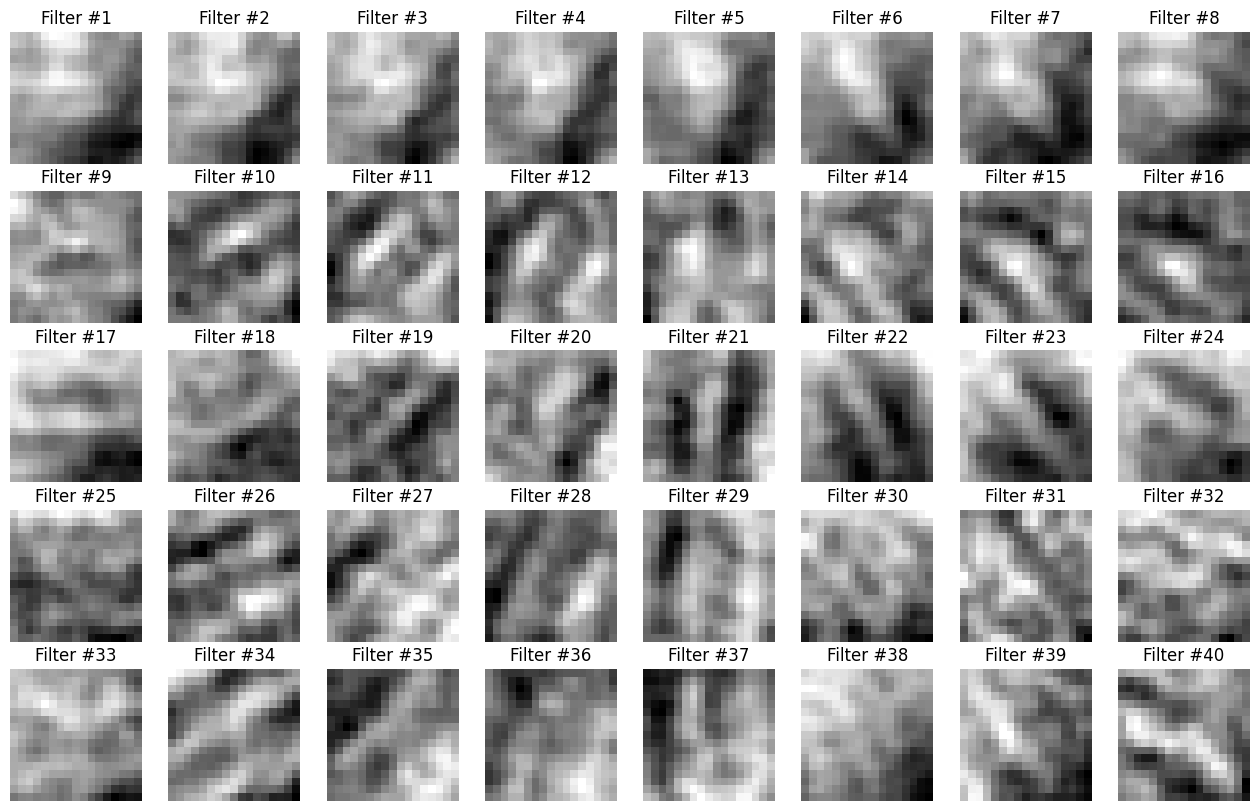

In [33]:
freeweights1stlayer = modelFCNNfree.get_weights()[0]
plot_filters(freeweights1stlayer[:,:,2,::3][:,:,np.newaxis,:])
print("Pesos tras el aprendizaje:")

## Alternativa CNN desde cero

Definimos un primer modelo convolucional de clasificación sencillo, con dos capas convolucionales, seguidas de un _"flatten"_ (por lo que la red no será completamente convolucional -esto es, _fully convolutional_, o FC-) y la correspondiente capa densa de salida, con activación _softmax_ para decidir entre las 9 clases:

In [34]:
num_classes = NC
input_shape = (TS, TS, 3)
newmodel = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(5, 5), activation="relu", padding="valid"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="valid"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

newmodel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 36, 36, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 18, 18, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │          20,485 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,413 (161.77 KB)

 Trainable params: 41,413 (161.77 KB)

 Non-trainable params: 0 (0.00 B)

Entrenamos el modelo y observamos que puede alcanzar un rendimiento de 98~99%, confiando en los pesos hallados por el gradiente descendente, sin haber tenido que "pensar" más que una arquitectura CNN convencional, muy similar a las utilizadas para problemas como [MNIST](https://es.wikipedia.org/wiki/Base_de_datos_MNIST):

In [35]:
%%time

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# Definimos el callback para guardar el mejor modelo según la métrica sobre el conjunto de validación:
checkpoint_callback = ModelCheckpoint("best_model.keras", monitor="val_sparse_categorical_accuracy", save_best_only=True, mode="max",verbose=1)

newmodel.compile(loss="sparse_categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),metrics=["sparse_categorical_accuracy"])
history = newmodel.fit(x=tiles_train,y=labels_train,validation_data=(tiles_val, labels_val),batch_size=64,epochs=30,callbacks=[checkpoint_callback])

# Recarga el mejor modelo guardado correspondiente a la mejor iteración
newmodel = load_model("best_model.keras")


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 1.4044 - sparse_categorical_accuracy: 0.3764
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.60417, saving model to best_model.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - loss: 1.4030 - sparse_categorical_accuracy: 0.3771 - val_loss: 0.8042 - val_sparse_categorical_accuracy: 0.6042
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.8166 - sparse_categorical_accuracy: 0.6288
Epoch 2: val_sparse_categorical_accuracy improved from 0.60417 to 0.80250, saving model to best_model.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - loss: 0.8164 - sparse_categorical_accuracy: 0.6290 - val_loss: 0.5907 - val_sparse_categorical_accuracy: 0.8025
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.7254 - sparse_categorical_accuracy: 0.6770
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.80250
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 125ms/step - loss: 0.7254 - sparse_categorical_

Dibujamos ahora las curvas de aprendizaje:

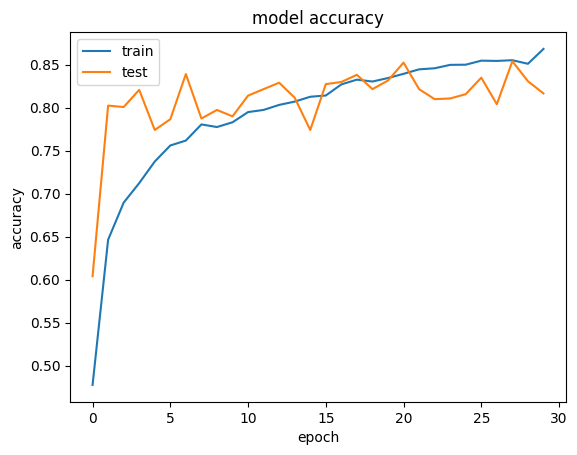

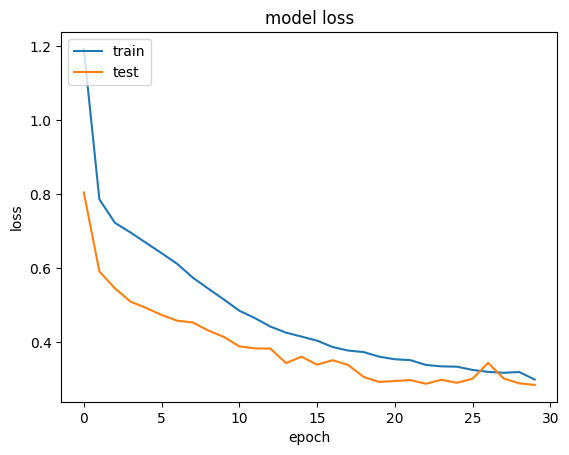

In [36]:
# Resumen de la historia del aprendizaje para la precisión final (accuracy):
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Resumen de la historia del aprendizaje para la función de pérdida (loss):
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Comprobamos los resultados del nuevo modelo, bastante mejores que los obtenidos con los modelos _hand engineered_ (~99% en validación, y un valor similar en el conjunto de test).

In [37]:
%%time

newmodel.evaluate(x=tiles_train,y=labels_train, batch_size=128)
newmodel.evaluate(x=tiles_val,y=labels_val, batch_size=128)
newmodel.evaluate(x=tiles_test,y=labels_test, batch_size=128)

75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.1457 - sparse_categorical_accuracy: 0.9417
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.1793 - sparse_categorical_accuracy: 0.9197
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.1665 - sparse_categorical_accuracy: 0.9217
CPU times: user 10.6 s, sys: 343 ms, total: 11 s
Wall time: 6.62 s


[0.3083028495311737, 0.8383333086967468]

### Conversión del modelo de clasificación anterior a una FCNN



Convertimos el modelo anterior para hacerlo completamente convolucional (FC):

In [40]:
num_classes = NC
input_shape = (None, None, 3)

newmodelFCC = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(5, 5), activation="relu", padding="valid"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="valid"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.5),
        layers.Conv2D(5, kernel_size=(8, 8), activation="softmax", padding="valid"), # Tamaño de kernel ajustado para salida 1x1 con cada parche de entrada 40x40
        # Ojo con el primer valor del parámetro: 9 ---> 5
    ]
)

newmodelFCC.summary()

print(newmodelFCC(np.array([tiles_train[0]])).shape)

# Copia de pesos del anterior modelo CNN no FC al nuevo modelo FC:
weights = newmodel.get_weights()
weights[-2] = weights[-2].reshape(8,8,64,5)   # (8,8,64,9)
newmodelFCC.set_weights(weights)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, None, None, 32)      │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, None, None, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, None, None, 64)      │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, None, None, 5)       │          20,485 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,413 (161.77 KB)

 Trainable params: 41,413 (161.77 KB)

 Non-trainable params: 0 (0.00 B)

(1, 1, 1, 5)


Finalmente, probamos con imagen completa de prueba que incluye las nueve clases, y comprobamos visualmente el mejor comportamiento de esta última red:

Forma del tensor con el batch de entrada: (82, 960, 3)
Forma del tensor con el batch de salida: (1, 11, 231, 5)



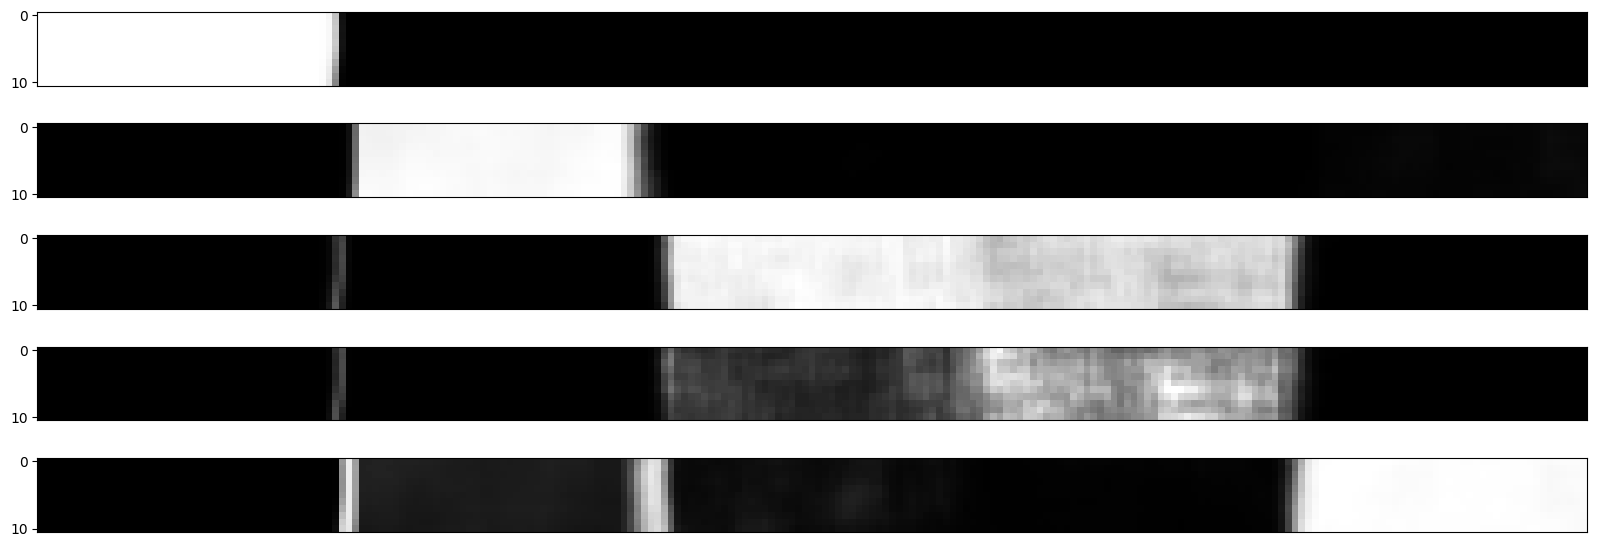

In [41]:
input_batch = np.array([imgtest])
output_tensor = newmodelFCC(input_batch)
print(f"Forma del tensor con el batch de entrada: {imgtest.shape}\n"
      f"Forma del tensor con el batch de salida: {output_tensor.shape}\n")
fig, axs = plt.subplots(NC, 1, figsize=(20.0,7.0))
for i in range(NC):
  axs[i].imshow(output_tensor[0,:,:,i], cmap="gray")
  axs[i].set_xticks([])

Se observa que los resultados mejoran de forma apreciable, con la diagonal principal bastante más marcada que en el caso del modelo "diseñado manualmente".

### Aspecto de los nuevos pesos de la primera capa

Sólo por curiosidad, vamos a estudiar los pesos obtenidos por la red para los pesos de la capa de entrada: observamos que, en este caso, ni siquiera parecen tener un significado geométrico claro, probablemente como corresponde a la variedad de nuestras texturas de entrada. En redes CNN más realistas, entrenadas con millones de imágenes reales, en estas primeras capas, por el contrario, suelen aparecer pesos formando algo así como pequeños detectores de bordes, esquinas, blobs, etc.

(5, 5, 96)


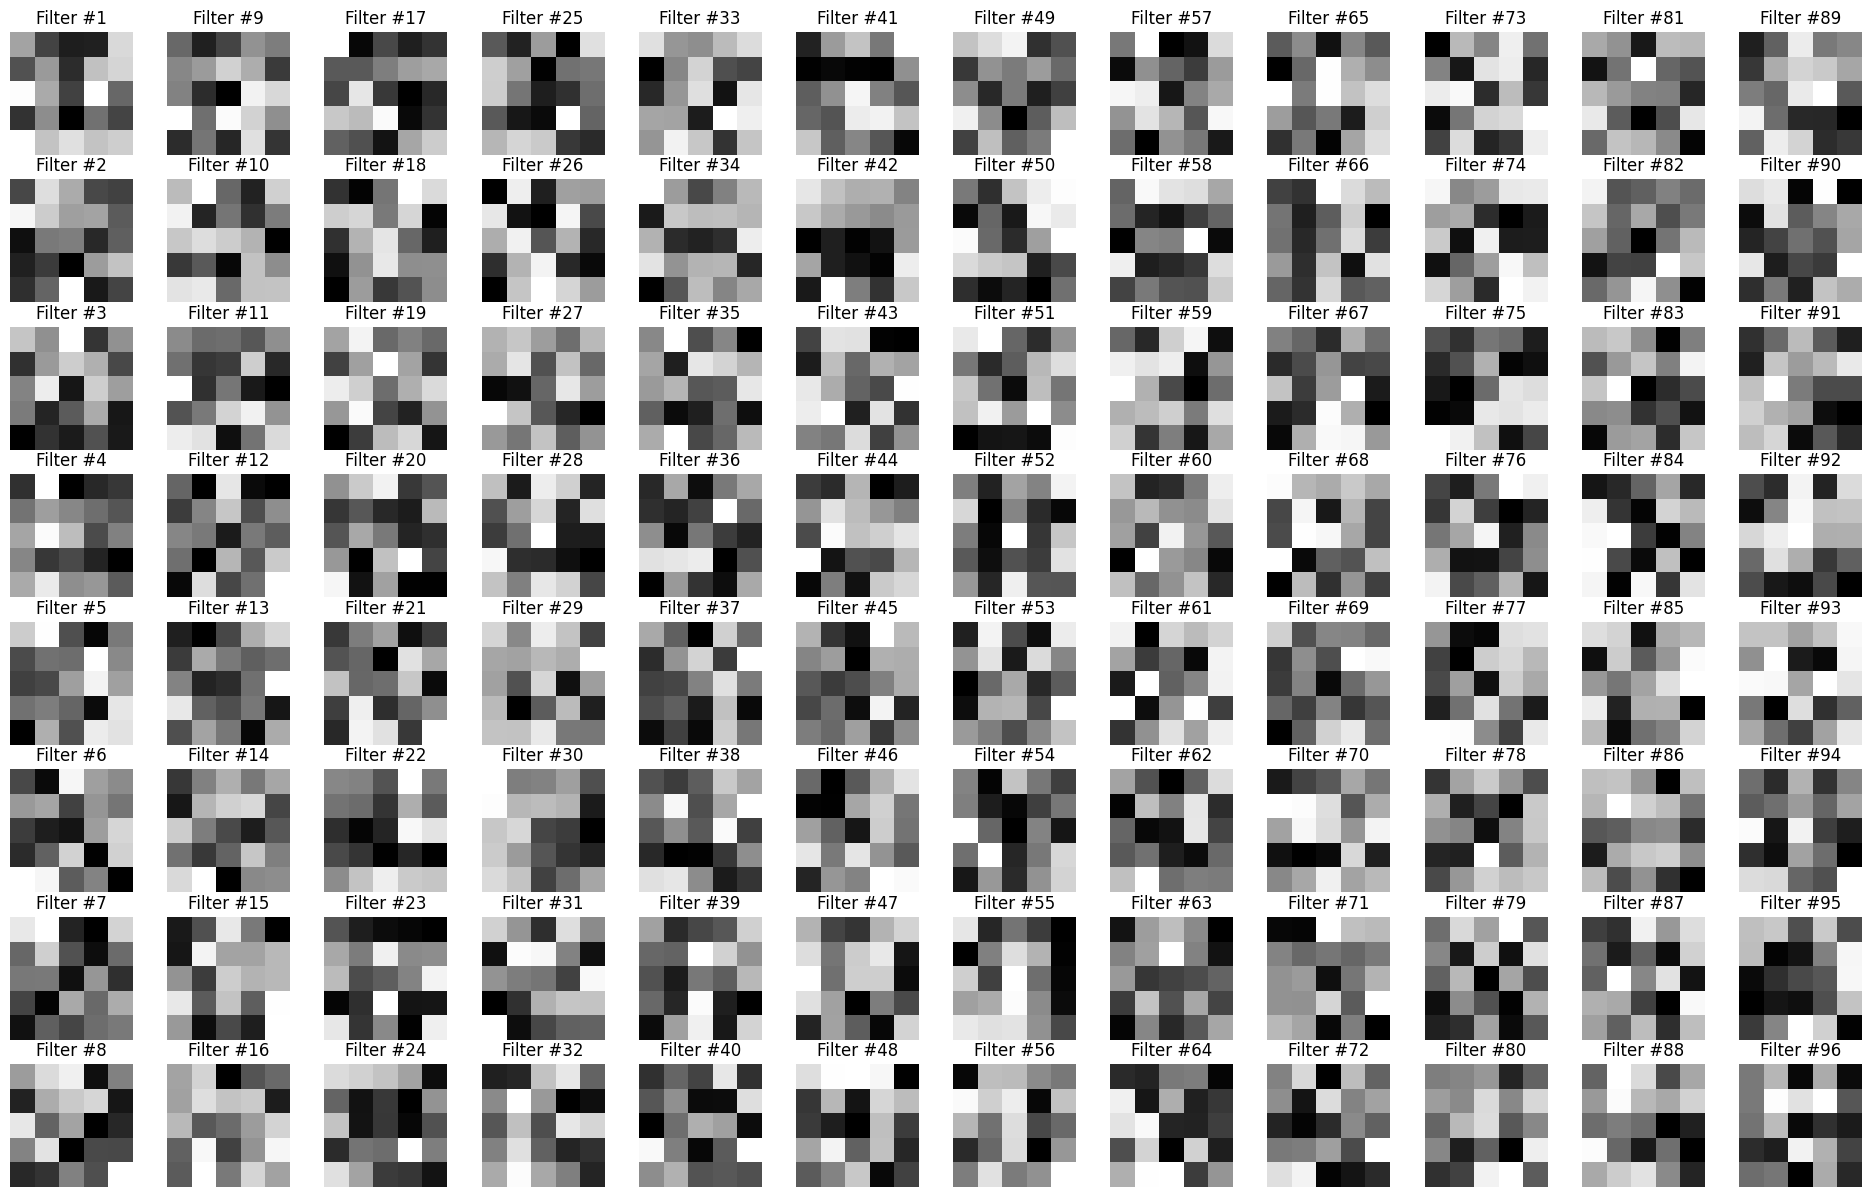

In [42]:
# weights[0].shape # (5, 5, 3, 32)
newfilters = weights[0].reshape(5,5,-1)
print(newfilters.shape)

def plot_new_filters(weights):
  fig, axs = plt.subplots(8, 12, figsize=(24.0,15.0))
  for i in range(96):
    axs[i%8,i//8].imshow(weights[:,:,i], cmap="gray")
    axs[i%8,i//8].axis("off")
    axs[i%8,i//8].set_title(f"Filter #{i+1}")

plot_new_filters(newfilters)

In [43]:
!date

Fri Dec 13 10:38:44 AM UTC 2024


# <div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>Ejercicio RC4B (0.5 pts)</strong></div>

En un apartado adicional al final de toda la ejecución se debe incluir un desarrollo textual
(esto es, en simples celdas markdown del notebook, estructuradas a voluntad) en el que se realice un estudio
comparativo básico con la ejecución sobre las nuevas texturas. Dicho estudio debe incluir una comparativa comentada con respecto a la ejecución original en relación a los siguientes aspectos (tanto para el modelo
hand-engineered como para la CNN entrenada desde cero):

1. Las precisiones obtenidas, tanto en training como en test (medidas precision, recall, f-score, matriz
de confusión).

2. Los tiempos de aprendizaje.

3. Las curvas de aprendizaje (loss function y model accuracy) para el modelo CNN.

4. La comparación visual de la segmentación de imágenes completas.

## **Análisis comparativo tras los cambios sugeridos en el ejercicio RC4A**

$\hspace{4.5 cm}$ ``Ejemplo de las 5 clases escogidas (etiquetado de menor a mayor de izquierda a derecha)``

![](https://drive.google.com/uc?id=1LLmVQ8QmbgmZRBboffYWO_4Dl-W8PsIa)

Como hemos escogido las texturas muy similares entre sí (al menos dos a dos) salvo la del arroz amarillo, es de esperar que en la clasificación el desempeño de tanto este modelo como el de la red convolucional, sean mejores detectando la primera textura. También podemos esperar algunas confusiones notables (esto ya dependerá bastante más de la arquitectura y/o entrenamiento de la red que se usa para clasificar) entre las clases 3 y 4 o 2 y 5.

En cuanto a los tiempo de aprendizaje, lo esperable es que el modelo para 5 clases converja antes, ya que el conjunto de datos de train en significativamente menor, y por tanto, cada época supone un cómputo menor, ya que el resto de hiperparámetros del entrenamiento (tamaño de los tiles, solapamiento, strides, proporcion del conjunto de train, tamaño del conjunto de validación, épocas, ... ) se han mantenido fijos para el experimento.

Sin embargo, dada nuestra primera observación sobre el rendimiento del nuevo modelo, quizá no podamos esperar que la curva de aprendizaje mejore en este caso, ya que a parte de tener un conjunto de train de menos tamaño neto, las texturas incorporadas deberían ser algo confusas de aprender dados sus parecidos, y por tanto, que el mismo modelo entrenado con estas 5 texturas necesitase más épocas para llegar a un rendimiento similar al modelo base para 9 clases con el resto de parámetros en *igualdad de condiciones*. De hecho, los aprecidos entre las texturas 2 y 5 son tan grandes que quizá no podamos igualar el rendimiento del modelo original solo aumentando las épocas de entrenamiento. Recordemos que entre las 9 texturas elegidas apra el modelo de ejemplo, solo las texturas 3 y 4 guardan una similitud remarcable. Las otras son muy distintas.

Sobre el test de segmentación de imágenes completas, lo esperable es que se confundan un poco las clases simmilares y que por tanto, de un resultado bastante peor que el modelo para 9 clases.

### ``Para el modelo hand-engineered``

#### 1. Precisión de la técnica en train y test

$\hspace{9 cm}$ **Métricas en train y test del modelo para 9 clases**  

![](https://drive.google.com/uc?id=1Csb-2q23sil-0zMwSZ9zdNl4whW_Lnmi)

<br>

<br>

<br>

<br>


$\hspace{9 cm}$ **Métricas en train y test del modelo para 5 clases**

![](https://drive.google.com/uc?id=1QrXo8_qBXeelRjxrwtvzYJnebPswu0-A) 

Tanto para 9 clases como para 5 y tanto en train como en test, vemos que la mejor métrica F1 se obtiene al seleccionar las features con filtros de Gabor RGB. Correspondientes a la última tabla en cada caso.

En el conjunto de train para 5 clases el esempeño es bastante bueno, ya que los F1 scores por clase oscilan entre 0.96 y 1. y lo mismo ocurre para el dataset de 9 clases. Estas métricas contrastan mucho con las de la primera tabla en cualquier caso (simple imagen en escala de gris o rgb).

Si nos fijamos en el F1 score, podemos ver que utilizando filtro de Gabor RGB, la métrica es mejor sobre el conjunto de test de 5 clases (aunque no muy superior) y lo mismo ocurre en general para las otras métricas al tener en cuenta el color de las imágenes. Al quedarnos con imágenes en escala de grises, las diferencias entre las métricas es menos notable y en general dan valores que no son tan buenos como los de su opción "equivalente" en escala de gris.

$\hspace{10.5 cm}$ **Matriz de confusión en train con 9 clases**  

![](https://drive.google.com/uc?id=10D1iPkA9iNedl2TA8XNmF3j_YYqmp9Tt) 

<br>

<br>

<br>

<br>


$\hspace{10.5 cm}$ **Matriz de confusión en train con 5 clases**  


![](https://drive.google.com/uc?id=1XS5ivKzOuYeRFFZni9rfwTdQDSEOFCTD)


EL modelo hand-engineered con 9 clases clasifica muy muy bien al emplear filtros de Gabor con RGB. Solo comete algunos errores significativos con las clases (3,4) (2 y 3 en el gráfico) y un ligero error en las clases (6,8) (5 y 7 en el gráfico). Esto se debe a que las clases 3 y 4 se parecen mucho entre sí; pero las confusioness entre clases 6 y 8 me resultan verdaderamente sorprendentes, ya que son texturas que no se parecen en absoluto.

En cuanto al caso de 5 clases con el mismo filtro, vemos confusiones notables entre las clases 3 y 4 (de forma bastante simétrica además) y graves confusiones al clasificar la clase 5 como clase 2.

Al eliminar el color y emplear filtros de Gabor en escala de gris, las clasificaciones empeoran considerablemente, tanto para 9 clases como para 5. Merece la pena destacar que al hacer esto, la precisión abosluta que encontrabamos al clasificar imágenes de la clase 1 en RGB, se pierde y ya encontramos algunos pocos fallos en train al clasificar la textura 1 (arroz amarillo). Por otro lado, la confusión entre clases 3,4 y 5 se ve muy incrementada al dejar de lado en color. De hecho, como es lógico, las texturas de 2 en adelante se parecen bastante si no miramos el color, y esto ha sido capaz de confundir al detector hand-engineered bastante incluso en datos de train. La clase que peor se clasifica con filtros de Gabor en escala de gris es la 5 (para el caso de 5 clases) y para el caso de 9 clases son la 4 y la 8, seguida de la 9.

Aquí además es más evidente el detectar las confusiones entre clase 3 y 4 que surgen en el modelo al pasar del filtro RGB al filtro de grises para 9 clases.

$\hspace{10.5 cm}$ **Matriz de confusión en test con 9 clases**  

![](https://drive.google.com/uc?id=1_hOOF-JdlAFWmIIJsS3Mu7eL47OBzEwd)

<br>

<br>

<br>

<br>


<!-- $\hspace{10.5 cm}$ **Matriz de confusión en test con 5 clases**   -->


![](https://drive.google.com/uc?id=1BRognNTLQlkA7SW8mSVV9VgDAyz6w7Ro)  

Fijándonos en la estructura de color de las amtrices de confusión, podemos extraer la conclusión de que en general, sobre el conjunto de test ocurre lo mismo que sobre el conjunto de train pero de forma más acentuada en todos los casos y para ambos modelos (de 9 y 5 clases) las confusiones se acentúan bastante salvo en el caso del modelo con filtro RGB, donde se contienen algo más.

Analizando la mejor versión de ambos modelos (la del filtro RGB) nos damos cuenta de que a la hora de la verdad (test) las confusiones que se dan son entre las clases 3 y 4 para el modelo de 0 clases, y para las clases 3 y 4 de nuevo para el modelo de 5 clases. Justo estas parejas de clases son en cada uno de los casos el par más parecido de los disponibles, y eso queda reflejado en el rendimiento del modelo hand-engineered. De hecho, veremos a continuación como esto se ve reflejado en la capacidad de segmentación de ambos modelos.

#### 4. Comparación visual de la segmentación de imágenes completas

<img src="CVFiles2/segmentation_9_color.png" alt="" style="width:95%; height:auto;">


$\hspace{10 cm}$ **Test de segmentación con 9 clases**  

![](https://drive.google.com/uc?id=1Qdy6HtBZDXmCdZ8GG5m1IxeFXXioRj1b) 

<br>

<br>

<br>

<br>

![](https://drive.google.com/uc?id=1LLmVQ8QmbgmZRBboffYWO_4Dl-W8PsIa) 

<br>

<br>


$\hspace{10 cm}$ **Test de segmentación con 5 clases**  


![](https://drive.google.com/uc?id=1ClXFQttl1ShMlTCmUL2kNRRm4Xjbfgaf) 

En el test de segmentación para el modelo de features hand-engineered podemos ver que en el caso de 9 clases hay ligeras confusiones en la segmentación de la imagen, que se acentúan bastante en los lugares asociados a las clases 3 y 4. Las "entradas fuera de la diagonal" en el resto de posiciones generan algo de ruido pero no llega a ser indicador de graves confusiones. Sigue estando lejos aun así de una diuagonal perfecta o casi perfecta, lo cual indica que el modelo es capaz de realizar un trabajo de segmentación razonable pero que está lejos de ser bueno, principalmente por las grandes confusinoes entre las clases 3 y 4.

La segmentación proporcionada por el modelo de clasificación de 5 clases se diferencia de la anterior (para 9 clases) en que tiene un menor número de "tipos de confusiones" en general (lo cual es entendible ya que pasamos de 9 a solo 5 clases) pero por contra, las confusiones de cada tipo son en general más graves y esto hace que ya no se aprecie con tanta facilidad un "gráfico diagonal". De nuevo las clases 3 y 4 perturban bastante la segmentación diagonal ideal, pero la confusión de las clases 2 y 5 no se queda atrás. Vemos que la única clase que se segmenta perfectamente sin confusión es la 1, y la clase 2 también se segmenta perfectamente. Es a la hora de segmentar la clase 5 cuando enconrtamos confusiones respecto de la clase 2, aunque la clase 5 se segmente perfectamente. Es decir, el clasificador de las clase 5 no solo detecta clase 5 sino que también muchas instancias de la clase 2 lo consiguen engañar y que las clasifique como clase 5. Esto no ocurre al revés porque como ya hemos comentado, el clasificador de clase 2 a penas clasifica instancias de la clase 5 como 2.

Donde el desempeño de clasificaiones decae considerablemente es en las clases 3 y 4, donde podemos apreciar confusiones "en ambos sentidos".

### ``Para el modelo de CNN entrenado desde cero``

#### 2. Tiempos de aprendizaje

El modelo con CNN para 9 clases (con hiperparámetros de entrenamiento idénticos en ambos casos) tarda 43 segundos en entrenarse con la GPU de colab, mientras que el modelo CNN para 5 clases tarda 25 segundos en las mismas condiciones. Es de esperar ya que estamos reduciendo el tamaño del modelo bastante al pasar de 9 clases a 5 clases en igualdad de hiperparámetros de entrenamiento. Como vemos es un modelo muy sencillo en cuanto a cómputo en GPU estándar, y tarda mucho menos de lo que quizá pudiéramos esperar a priori, teniendo en cuenta que estamos entrenando con 30 épocas.

Creo que es una buena manera de comprobar la eficiencia computacional de los modelos convolucionales respecto a otro tipo de arquitecturas de DL en visión.

**NOTA:** Eneste notebook se puede ver que el tiempo de entrenamiento de la FCNN para 5 clases es de 15 minutos. Nos quedamos sin GPU en colab y la ultima ejecutión tuvo que ser con CPU, pero a posteriori se realizó la ejecución con GPU renovada y el tiempo era el que aquí comentamos. Podemos verlo en la siguiente imagen:

![](https://drive.google.com/uc?id=1cHZCwICyF7rrXwalbbga6qIQg4uXumfM) 

#### 3. Curvas de aprendizaje

$\hspace{3 cm}$ **Curva de accuracy en train y test con 9 clases**  $\hspace{3 cm}$ **Curva de loss function en train y test con 9 clases**  

![](https://drive.google.com/uc?id=152IJ80WUZISlj6EsmKmKu8KfUTU555xg) ![](https://drive.google.com/uc?id=1HwsAS__8E9N_37lIoZN65Cqw0uM1zvDl)

<br> 

Las curvas de aprendizaje están mejor definidas en train, tanto para el accuracy como para la loss function. En test, ambas curvas se muestran algio más erráticas y aunque hay cierta tendencia visible, no es muy marcada, como pasa en train. Algo que es sorprendente sobre la gráfica del accuracy es que la métrica es mayor en test que en train por lo general, conforme avanzan las épocas. Esto no es lo habitual y quizá se deba a tener un conjunto de test mucho más pequeño que el de train o a que el conjunto de test no sea suficientemente heterogéneo y contenga imágenes que en promedio sean más sencillas de clasificar que las del conjunto de train.

En cuanto a la función de pérdida, podemos comentar que sucede algo similar: toma valores más bajos en test que en train. Esta tiene una tendencia más marcada (menos errática) que el accuracy y en general, existe bastante correlación (negativa) entre ambas gráficas (accuracy y loss) tanto en train como en test.

$\hspace{3 cm}$ **Curva de accuracy en train y test con 5 clases**   $\hspace{3 cm}$ **Curva de loss function en train y test con 5 clases**  

![](https://drive.google.com/uc?id=1PJznUlYqhPlyqRP2S5gpftpg4eQ8D4nv)  ![](https://drive.google.com/uc?id=1gESsGieSOQGCHjqFwhymPmKe7aH2zvb0)  


Para el entrenamiento del modelo de 5 clases las curvas de accuracy "tienen más sentido", porque el accuracy comienza a ser mayor en train conforme aumentan las épocas de entrenamiento. Aunque también es cierto que la tendencia de la curva de accuracy es bastante más errática que en el modelo de 9 clases. De hecho, cerca de la época 27 podemos empezar a detectar el comienzo del overfitting mirando la gráfica del accuracy, pero si pasamos a la gráfica de la función de pérdida, vemos que aún queda algo de margen para aumentar ls épocas y que la pérdida siga bajando tanto en train como en test.

En la gráfica de la loss function las tendencias están mucho más amrcadas tanto en train como en test, pero sorprende de nuevo el hecho de que la pérdida sea menor en test que en train a lo largo de las épocas, cuando incluso esto no ocurre con el accuracy en este caso.

De forma general, se puede comparar el accuracy y la loss según qué modelo (9 o 5 clases) y los resultados son los siguientes al final del entrenamiento:

<br>

**9 clases:** $\hspace{2 cm}$ accuracy train: 0.95 $\hspace{1 cm}$ accuracy test: 0.98 $\hspace{1 cm}$ loss train: 0.18 $\hspace{1 cm}$ loss train: 0.16

**5 clases:** $\hspace{2 cm}$ accuracy train: 0.88 $\hspace{1 cm}$ accuracy test: 0.8 $\hspace{1 cm}$ loss train: 0.33 $\hspace{1 cm}$ loss train: 0.32

<br>


El desempeño con la FCNN es algo mejor en el modelo para 9 clases, hablando en términos generales. Principalmente debido a la intención que comentábamos al principio de seleccionar clases más aprecidas entre sí (o dos a dos) que las que traía la notebook de clase por defecto.

#### 4. Comparación visual de la segmentación de imágenes completas

$\hspace{10.5 cm}$ **Test de segmentación con 9 clases**  

![](https://drive.google.com/uc?id=1QlDmH6EvfvOQELJzIZnbZjzBoxgi_pWb)

<br>

<br>

![](https://drive.google.com/uc?id=1wJza6iYPyiGaYQ3gmiLSrl7OQQTtiNT2) 

<br>

<br>

<br>

<br>


$\hspace{10.5 cm}$ **Test de segmentación con 5 clases**

![](https://drive.google.com/uc?id=1LLmVQ8QmbgmZRBboffYWO_4Dl-W8PsIa)

<br>

<br>

![](https://drive.google.com/uc?id=149M-ooemeLcem3lnd0qV_LSijtOsnjFz) 

Este test de segmentación para 9 clases mejora respecto del anterior: la linea diagonal de segmentaciones es algo más clara y el "ruido" de fuera de la diagonal se ve ligeramente suavizado. Sobre todo, mejora las confusiones de clase 4 con clase 3.

En cuanto a la segmentación de 5 clases, el modelo de CNN suaviza basatante los errores de segmentación de fuera de la daigonal. Para la clase 5, y en general clases clases 3 y 4 se segmentan mucho mejor. Sin embargo podemos encontrarle un pega y es que las confusiones de clase 3 con clase 4 aumentan mucho, y vemos que el clasificador de la clase 3 es incapaz de segmentar estas clases cuando aparecen juntas. Este tipo de error no eran tan evidente en el test del modelo hand-engineered.